In [ ]:
!pip install monai
!git clone https://github.com/jesusalzate/SAM-UNETR.git
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
Cloning into 'SAM-UNETR'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 46 (delta 14), reused 17 (delta 4), pack-reused 0
Receiving objects: 100% (46/46), 11.97 MiB | 13.63 MiB/s, done.
Resolving deltas: 100% (14/14), done.
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-1ud8ay43
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-1ud8ay43
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=0572a8886aa550ec62ddaea13f574e04371788a16c30a0b483349aea3acf802c
  Stored in directory: /tmp

In [ ]:
!mv "/content/drive/MyDrive/PROYECTO_FINAL/SAM-UNETR" "/content/drive/MyDrive/PROYECTO_FINAL/SAM_UNETR"

In [ ]:
%cd /content/drive/MyDrive/PROYECTO_FINAL

/content/drive/.shortcut-targets-by-id/1kCNo1cQAIUOquu9VOstONYUMEMW_reEl/PROYECTO_FINAL


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib

import monai
from monai.networks.nets import UNETR, UNet
from monai.utils import first
from monai.data import CacheDataset, DataLoader, Dataset #, decollate_batch
from monai.inferers import SliceInferer


from time import sleep

import numpy as np
import matplotlib.pyplot as plt
import cv2

from SAM_UNETR.samunetr.SAMUNETR_V2 import SAMUNETR

Dowloand weigths

In [ ]:
from segment_anything import sam_model_registry, SamPredictor
import torch

def dowloand_weigths(path_save_img_encoder):
  path = path_save_img_encoder+'/sam_image_encoder.pth'
  sam_checkpoint = "sam_vit_h_4b8939.pth"
  model_type = "vit_h"
  sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
  torch.save(sam.image_encoder.state_dict(),path)
  return path

path_sam_encoder = dowloand_weigths('/content/drive/MyDrive/PROYECTO_FINAL')
!rm '/content/drive/MyDrive/PROYECTO_FINAL/sam_vit_h_4b8939.pth'

Try dataset

In [ ]:
def prepro_img(img):

  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  histr = cv2.calcHist([img_gray],[0],None,[256],[0,256])
  value_to_convert = np.argmax(histr)
  if value_to_convert >= 128 :
    img_gray = (255-img_gray)

  return img_gray

In [ ]:
x_train = np.load('/content/drive/MyDrive/PROYECTO_FINAL/X_train.npy').astype(np.float32)
y_train = np.load('/content/drive/MyDrive/PROYECTO_FINAL/y_train.npy').astype(np.int32)
x_test = np.load('/content/drive/MyDrive/PROYECTO_FINAL/X_test.npy').astype(np.float32)

In [ ]:
X_train_pre = np.ones((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
X_test_pre = np.ones((x_test.shape[0], x_test.shape[1], x_test.shape[2]))

for ind, x_img in enumerate(x_train[:]):
  x_g = prepro_img(x_img)
  X_train_pre[ind] = x_g


for ind, x_img in enumerate(x_test[:]):
  x_g = prepro_img(x_img)
  X_test_pre[ind] = x_g

X_vald = X_train_pre[603:670,:,:] #X_train_pre[603:670,:,:]
X_train= X_train_pre[0:603,:,:]#X_train_pre[0:603:,:]

y_vald = y_train[603:670:,:,:] #y_train[603:670:,:,:]
y_train = y_train[0:603,:,:] #y_train[0:603:,:,:]


------- IMAGEN:  0


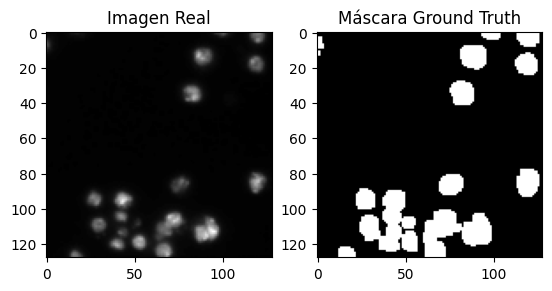

In [ ]:
# Mostramos la imagen y su máscara asociada
for i in range(1):
  print('------- IMAGEN: ',i)
  # Imagen real
  plt.subplot(1, 2, 1)
  plt.imshow(X_train[i], cmap='gray')
  plt.title('Imagen Real')

  # Máscara ground truth
  plt.subplot(1, 2, 2)
  plt.imshow(np.squeeze(y_train[i]), cmap='gray')
  plt.title('Máscara Ground Truth')
  plt.show()

------- IMAGEN:  0


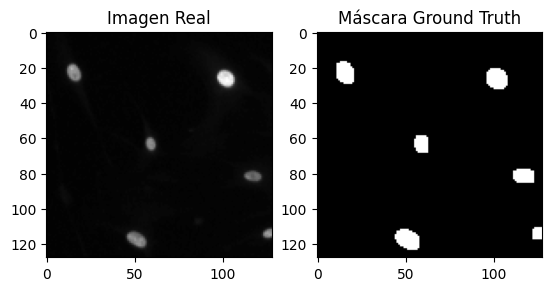

In [ ]:
for i in range(1):
  print('------- IMAGEN: ',i)
  # Imagen real
  plt.subplot(1, 2, 1)
  plt.imshow(X_vald[i], cmap='gray')
  plt.title('Imagen Real')

  # Máscara ground truth
  plt.subplot(1, 2, 2)
  plt.imshow(np.squeeze(y_vald[i]), cmap='gray')
  plt.title('Máscara Ground Truth')
  plt.show()

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_vald = np.expand_dims(X_vald, axis=-1)

In [ ]:
X_train = np.transpose(X_train, (0, 3, 1, 2))
y_train = np.transpose(y_train, (0, 3, 1, 2))
X_vald = np.transpose(X_vald, (0, 3, 1, 2))
y_vald = np.transpose(y_vald, (0, 3, 1, 2))

In [ ]:
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_vald:',X_vald.shape)
print('y_vald:',y_vald.shape)

X_train: (603, 1, 128, 128)
y_train: (603, 1, 128, 128)
X_vald: (67, 1, 128, 128)
y_vald: (67, 1, 128, 128)


In [ ]:
all_pixels = np.concatenate([imagen.flatten() for imagen in X_train])
mean_value = np.mean(all_pixels)
std_dev_value = np.std(all_pixels)

In [ ]:
all_pixels_vald = np.concatenate([imagen.flatten() for imagen in X_vald])
mean_value_vald  = np.mean(all_pixels_vald )
std_dev_value_vald  = np.std(all_pixels_vald )

In [ ]:
data_train = [{'image': img, 'label': seg} for img, seg in zip(X_train, y_train)]
data_vald = [{'image': img, 'label': seg} for img, seg in zip(X_vald, y_vald)]


In [ ]:
train_transforms = monai.transforms.Compose(

        [
         monai.transforms.AsDiscreted(keys=['label'],threshold=1),
         monai.transforms.ScaleIntensityd(keys=['image'],minv=0.0, maxv=255.0),
         monai.transforms.NormalizeIntensityd(keys=['image'],subtrahend= mean_value, divisor=std_dev_value),
         monai.transforms.RandRotate90d(keys=['image','label'],spatial_axes=[0,1],prob=0.3),
         monai.transforms.RandZoomd(keys=['image','label'],min_zoom=0.9,max_zoom=1.1,mode=['bilinear', 'nearest'],prob=0.2),
         monai.transforms.RandGaussianNoised(keys=['image'],mean=0,std=1,prob=0.1),
         monai.transforms.RandAdjustContrastd(keys=['image'],gamma=2.0,prob=0.15),
        ]
    )

valid_transforms = monai.transforms.Compose(

        [
         monai.transforms.AsDiscreted(keys=['label'],threshold=1),
         monai.transforms.ScaleIntensityd(keys=['image'],minv=0.0, maxv=255.0),
         monai.transforms.NormalizeIntensityd(keys=['image'],subtrahend= mean_value_vald, divisor=std_dev_value_vald),
        ]
    )

In [ ]:
train_ds = Dataset(data=data_train, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1,shuffle=False)

vald_ds = Dataset(data=data_vald, transform=valid_transforms)
vald_loader = DataLoader(vald_ds, batch_size=1,shuffle=False)

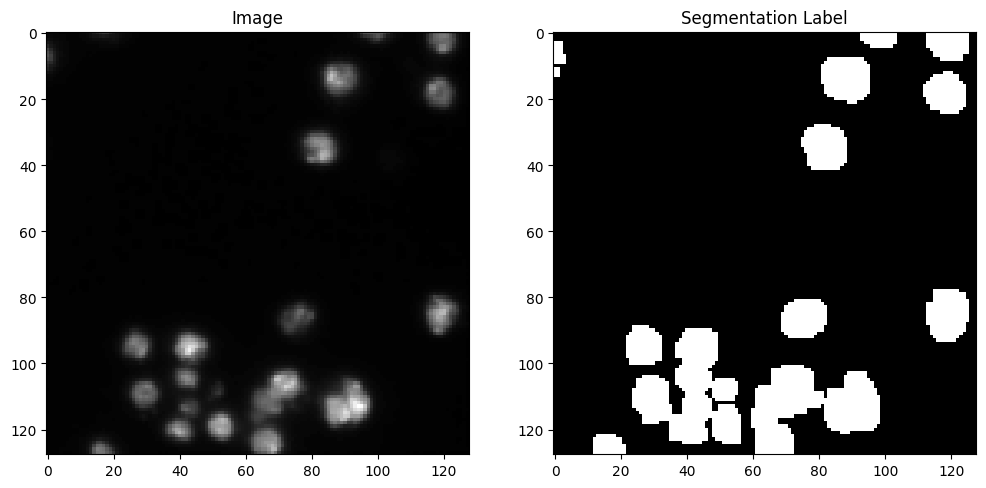

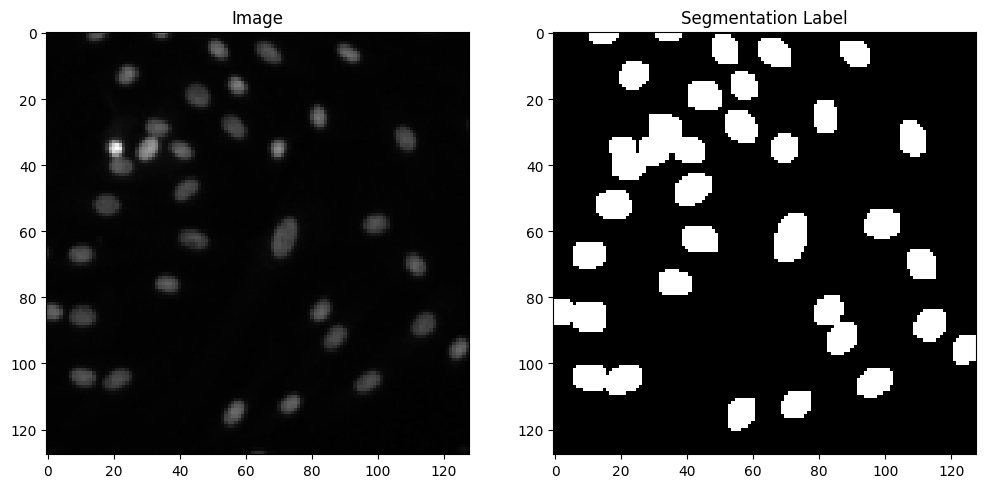

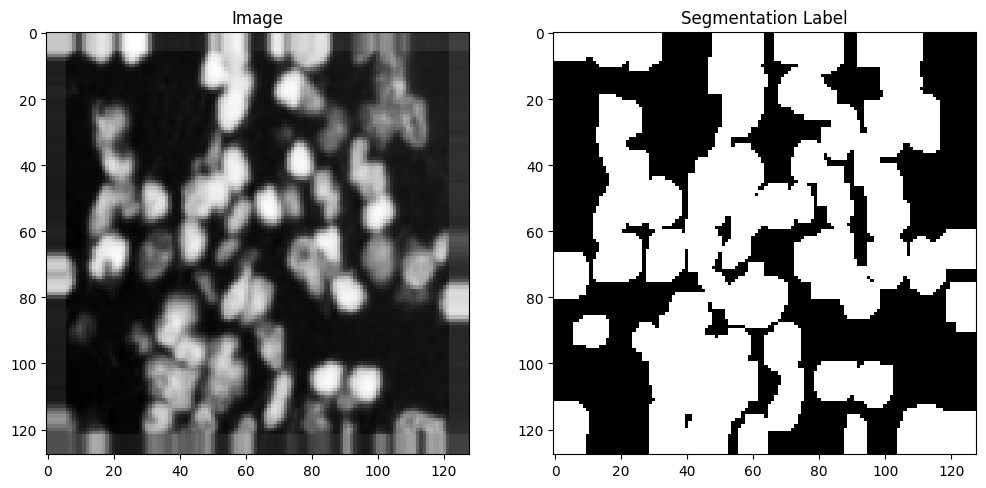

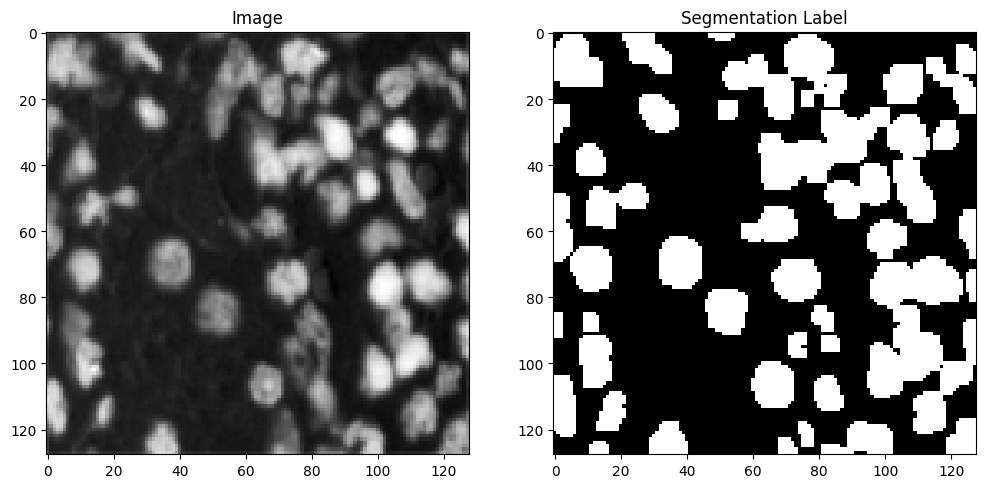

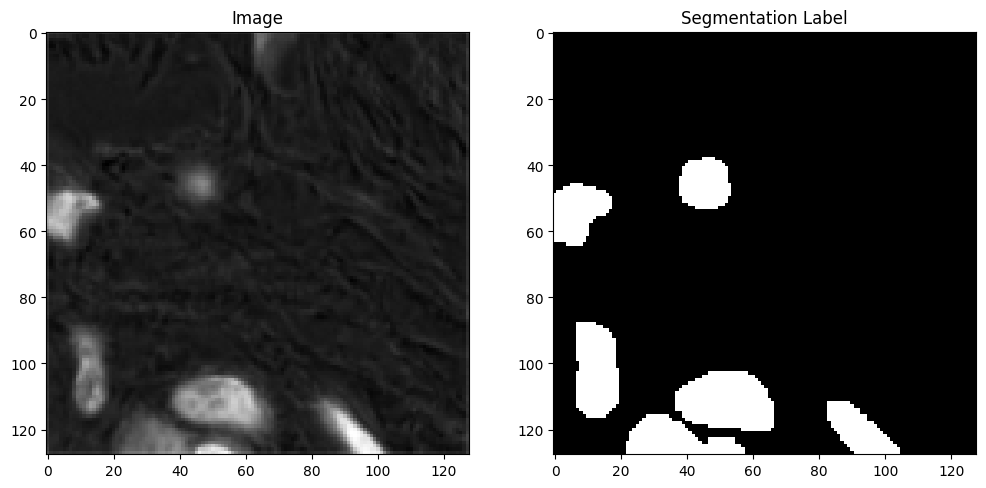

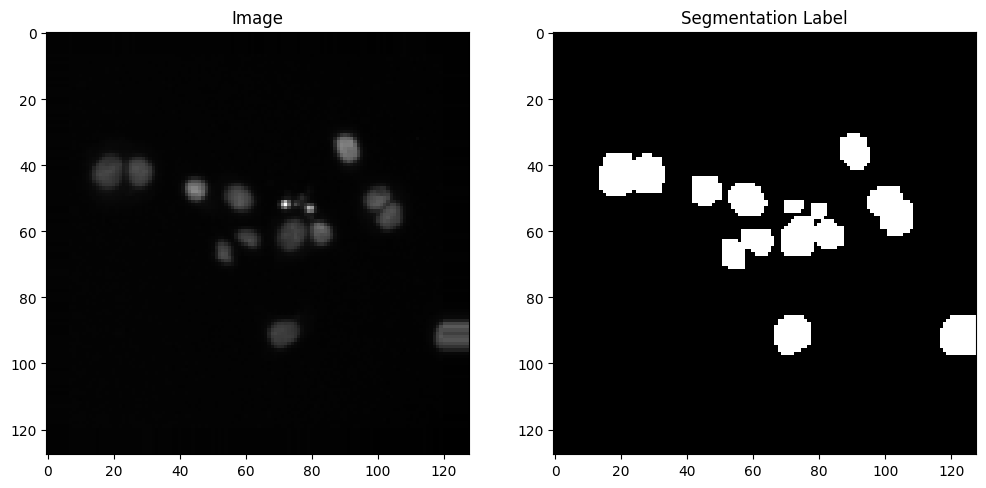

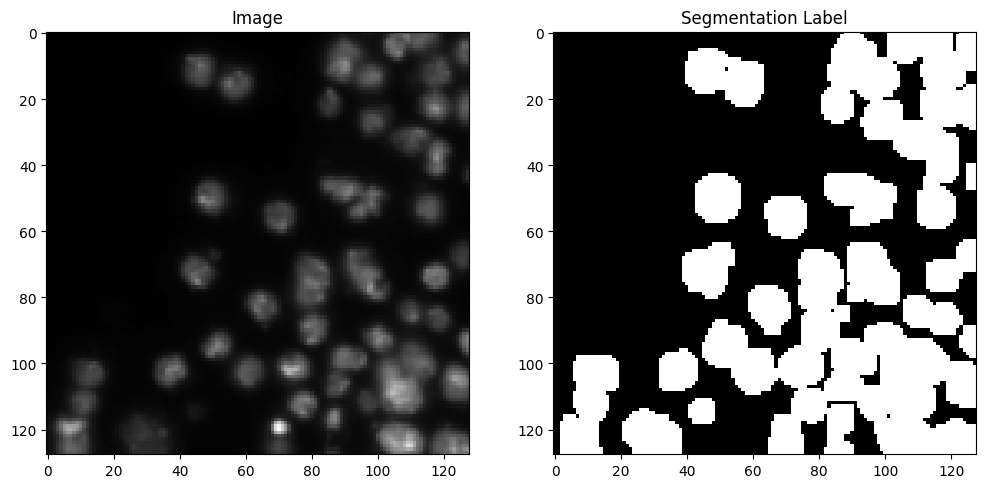

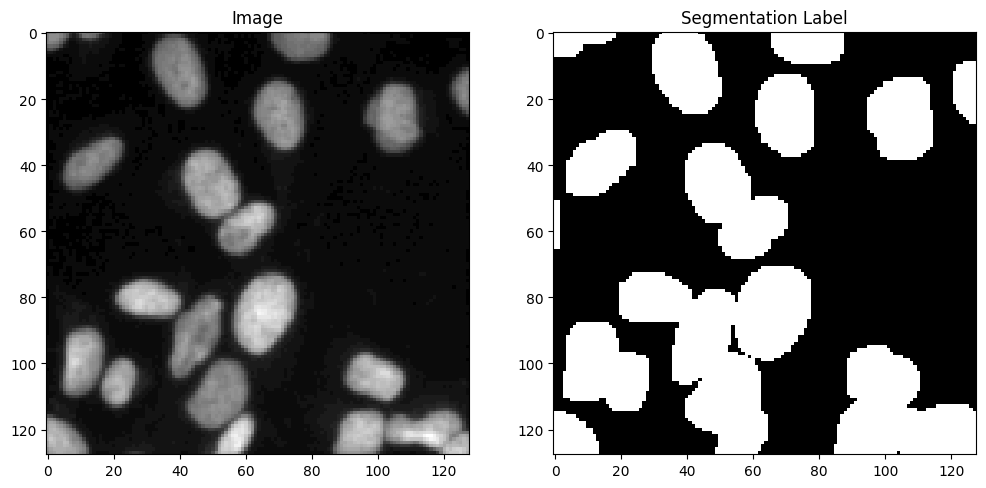

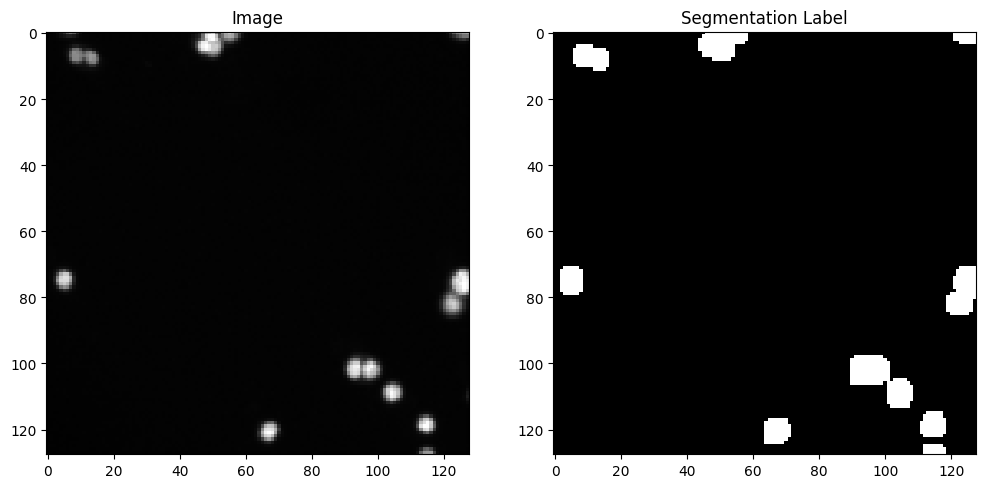

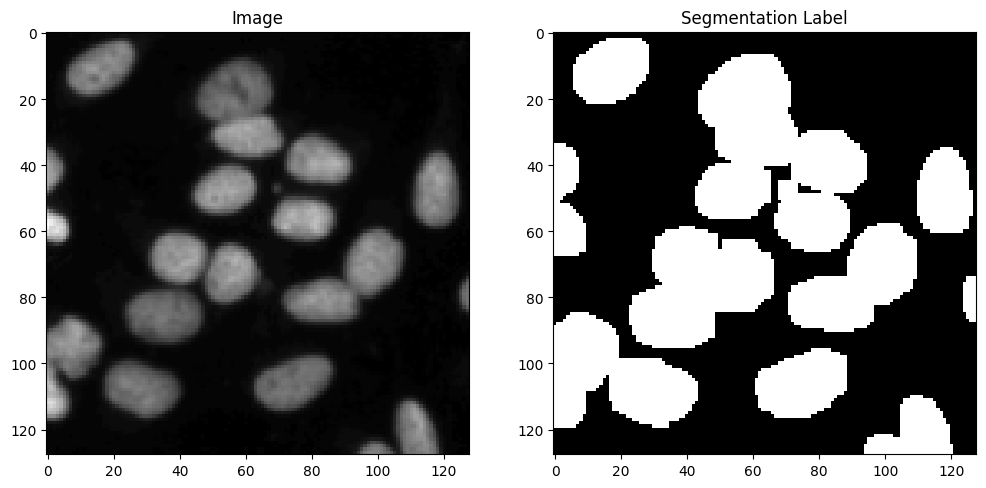

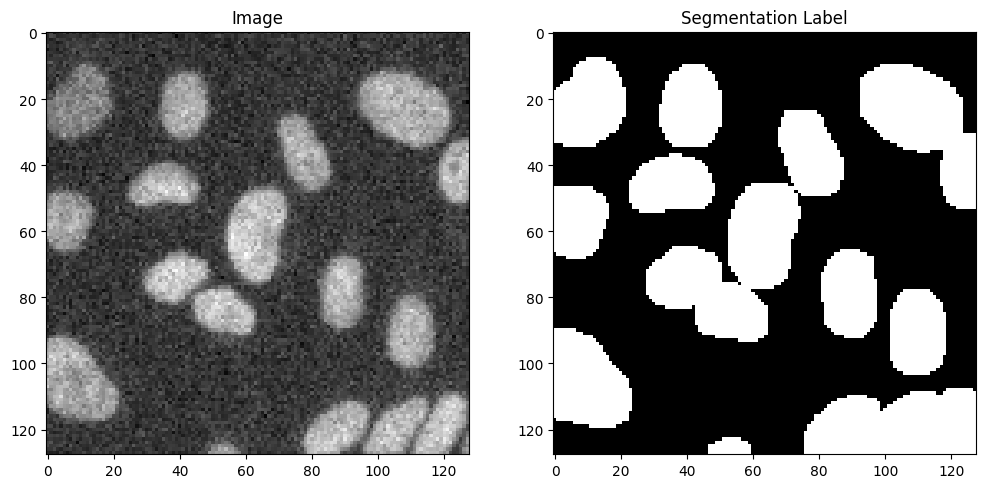

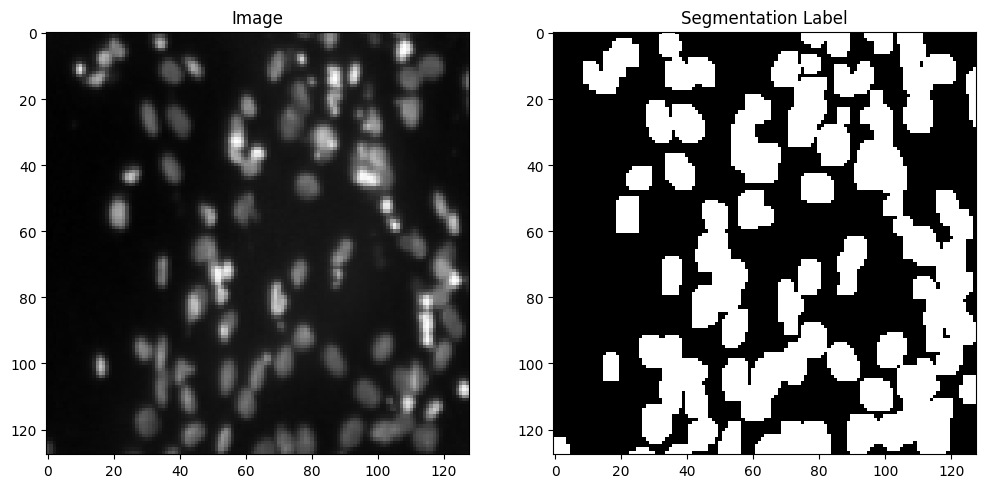

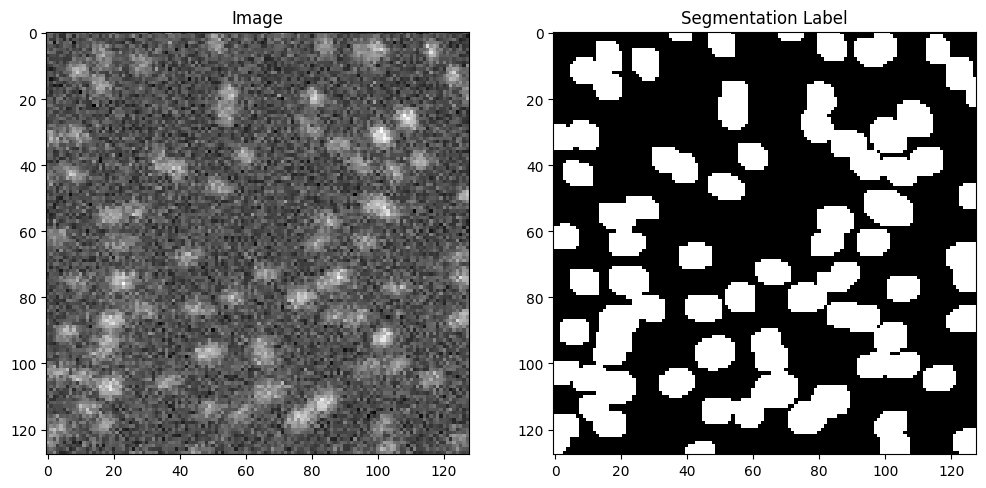

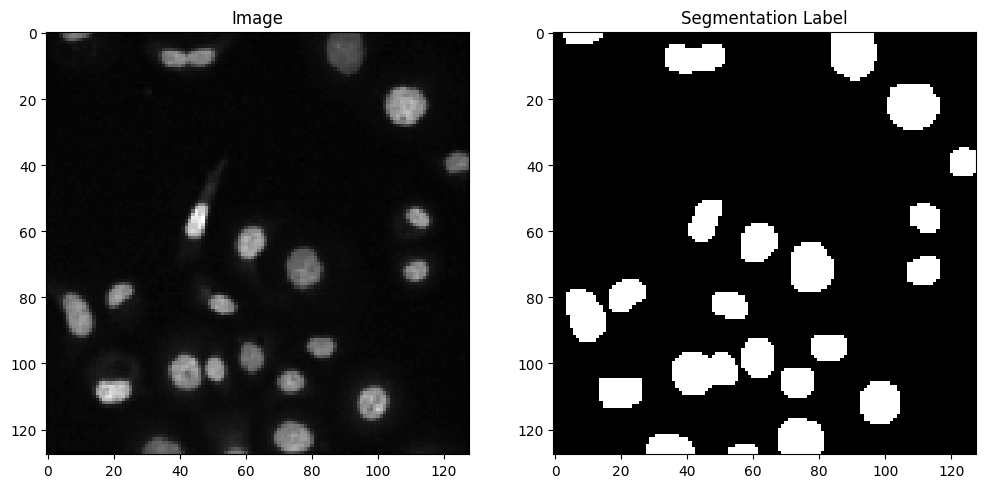

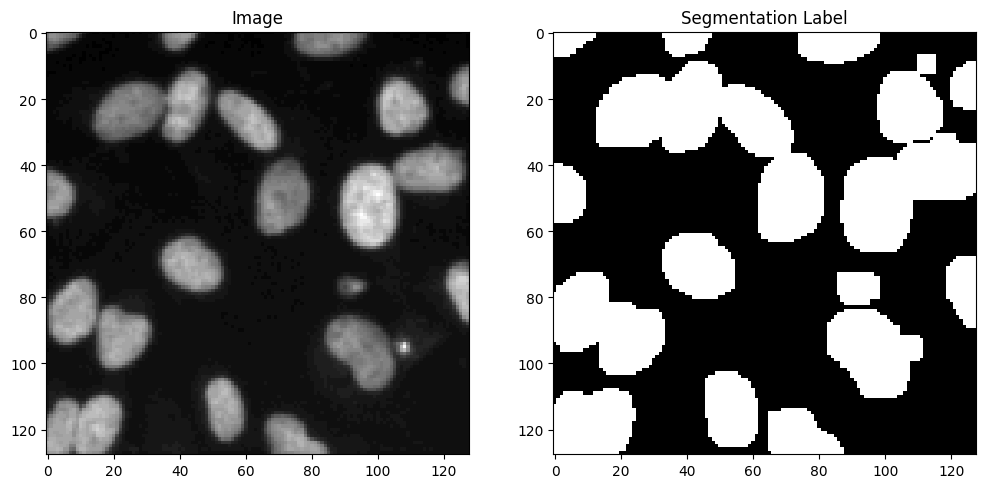

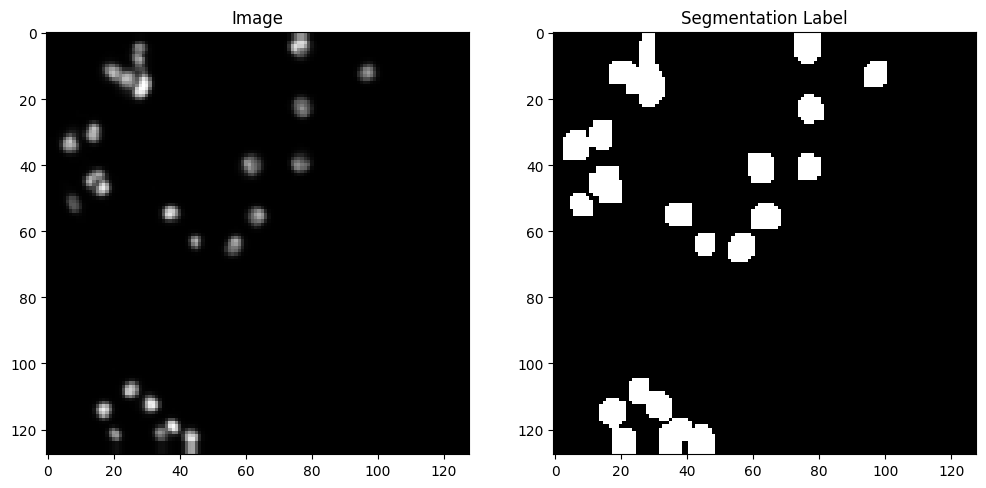

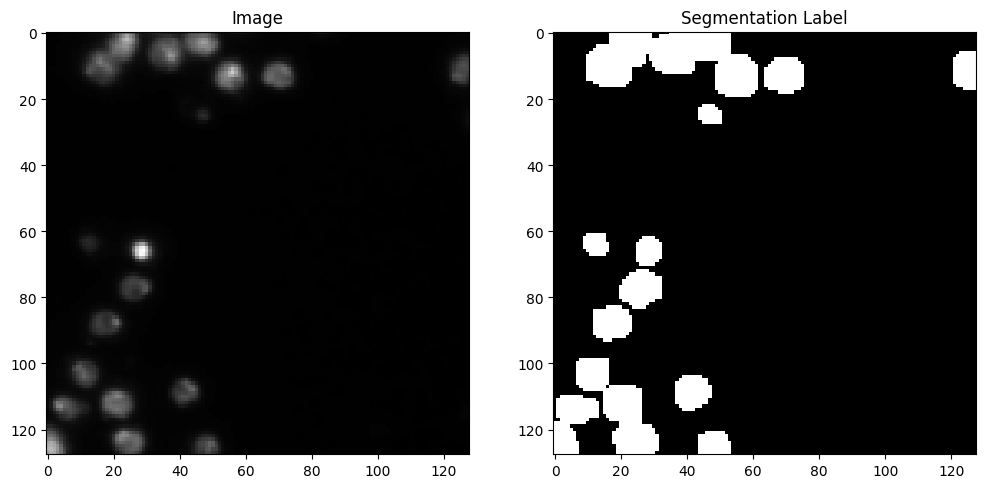

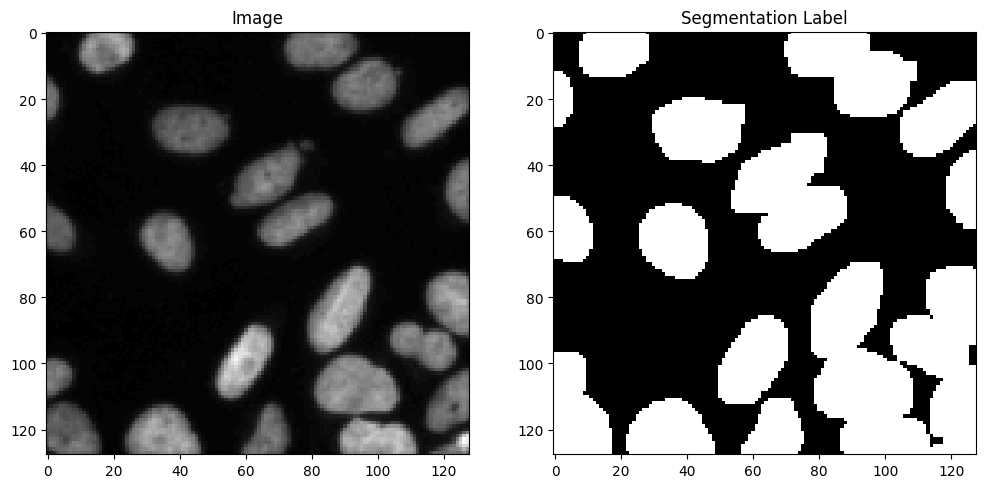

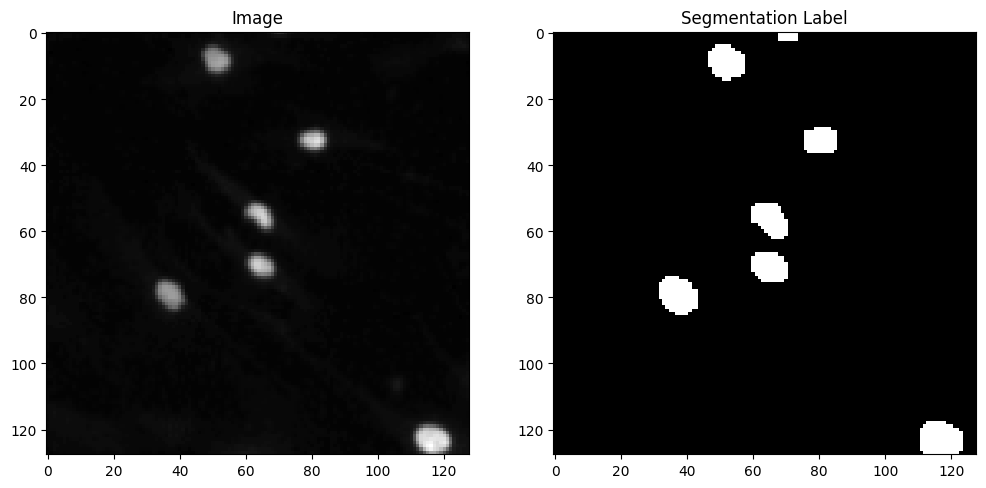

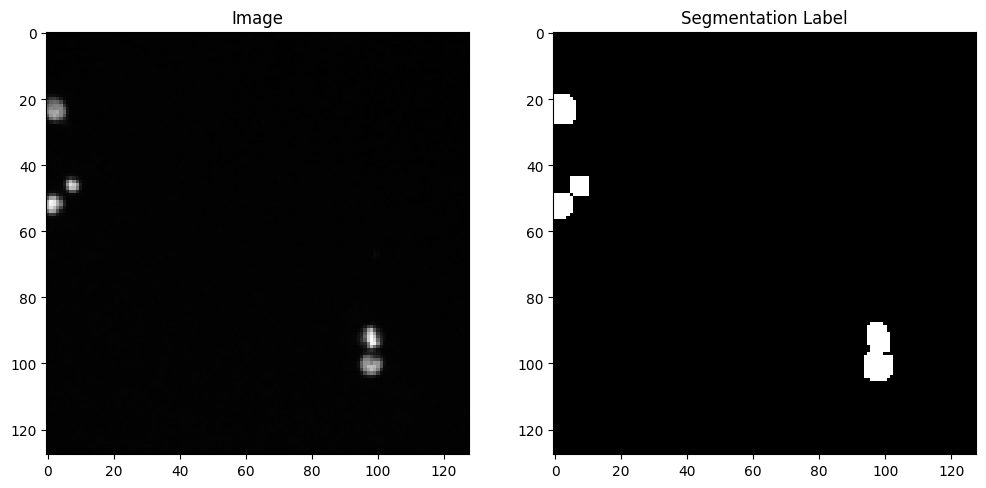

In [ ]:
contador = 0
for batch in train_loader:
  # Suponiendo que cada batch tiene 'img' y 'seg'
  image = batch['image'][0]  # [0] para obtener la primera imagen del batch
  label = batch['label'][0]  # [0] para obtener la primera etiqueta del batch

  # Convertir a un formato que matplotlib pueda mostrar
  # Asumiendo que tus imágenes son 2D, y usas 'np.squeeze' para eliminar dimensiones redundantes
  image_np = image.squeeze().detach().cpu().numpy()
  label_np = label.squeeze().detach().cpu().numpy()

  # Crear una figura y mostrar la imagen y la etiqueta
  plt.figure(figsize=(12, 6))


  plt.subplot(1, 2, 1)
  plt.imshow(image_np, cmap='gray')
  plt.title('Image')

  plt.subplot(1, 2, 2)
  plt.imshow(label_np, cmap='gray')
  plt.title('Segmentation Label')

  plt.show()

  contador += 1

  if contador == 20:
    break

# MODEL

In [ ]:
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model=SAMUNETR(path_img_encoder = './sam_image_encoder.pth',img_size=128,in_channels= 1,out_channels=1,trainable_encoder=False,pretrained=True).to(device)

Using SAMUNETR_V2
torch.Size([1280, 1, 16, 16])
Image encoder no trainable


In [ ]:
model.load_state_dict(torch.load('./Result/SAMUnetrV2_128x128_pretrained_D_S_B_60_200_last_weigths.pth'))

<All keys matched successfully>

In [ ]:
for name, param in model.named_parameters():
    print(f"Nombre: {name}")
    print(f"Tipo: {'Entrenable' if param.requires_grad else 'No entrenable'}")
    print(f"Forma: {param.size()}")
    print()

Nombre: image_encoder_vit.pos_embed
Tipo: No entrenable
Forma: torch.Size([1, 8, 8, 1280])

Nombre: image_encoder_vit.patch_embed.proj.weight
Tipo: No entrenable
Forma: torch.Size([1280, 1, 16, 16])

Nombre: image_encoder_vit.patch_embed.proj.bias
Tipo: No entrenable
Forma: torch.Size([1280])

Nombre: image_encoder_vit.blocks.0.norm1.weight
Tipo: No entrenable
Forma: torch.Size([1280])

Nombre: image_encoder_vit.blocks.0.norm1.bias
Tipo: No entrenable
Forma: torch.Size([1280])

Nombre: image_encoder_vit.blocks.0.attn.rel_pos_h
Tipo: No entrenable
Forma: torch.Size([27, 80])

Nombre: image_encoder_vit.blocks.0.attn.rel_pos_w
Tipo: No entrenable
Forma: torch.Size([27, 80])

Nombre: image_encoder_vit.blocks.0.attn.qkv.weight
Tipo: No entrenable
Forma: torch.Size([3840, 1280])

Nombre: image_encoder_vit.blocks.0.attn.qkv.bias
Tipo: No entrenable
Forma: torch.Size([3840])

Nombre: image_encoder_vit.blocks.0.attn.proj.weight
Tipo: No entrenable
Forma: torch.Size([1280, 1280])

Nombre: image_

In [ ]:
loss_function = monai.losses.DiceFocalLoss(sigmoid=True,softmax=False,include_background=True)
torch.backends.cudnn.benchmark = True
optimizer = monai.optimizers.Novograd(model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
data_in=(train_loader,vald_loader)
model_dir='./Result'

In [ ]:
train2D_(model, data_in, loss_function, optimizer, 200, model_dir,device=device,name='SAMUnetrV2_128x128_pretrained_D_S_B')

----------
epoch 1/200


Epoch 1: 100%|██████████| 603/603 [01:51<00:00,  5.41batch/s, dice_score=0.0433, loss=0.96]


--------------------
Epoch_loss: 0.4180
Epoch_metric: 0.0433
IoU_metric: 0.5326
test_loss_epoch: 0.2009
test_dice_epoch: 0.1138
test_iou_epoch: 0.7325
current epoch: 1 current mean dice: 0.1138
best mean dice: 0.1138 at epoch: 1
----------
epoch 2/200


Epoch 2: 100%|██████████| 603/603 [02:10<00:00,  4.63batch/s, dice_score=0.095, loss=0.302]


--------------------
Epoch_loss: 0.2580
Epoch_metric: 0.0950
IoU_metric: 0.7136
test_loss_epoch: 0.1569
test_dice_epoch: 0.1417
test_iou_epoch: 0.7927
current epoch: 2 current mean dice: 0.1417
best mean dice: 0.1417 at epoch: 2
----------
epoch 3/200


Epoch 3: 100%|██████████| 603/603 [02:10<00:00,  4.64batch/s, dice_score=0.0946, loss=0.266]


--------------------
Epoch_loss: 0.2269
Epoch_metric: 0.0946
IoU_metric: 0.7429
test_loss_epoch: 0.1367
test_dice_epoch: 0.1320
test_iou_epoch: 0.8165
current epoch: 3 current mean dice: 0.1320
best mean dice: 0.1320 at epoch: 3
----------
epoch 4/200


Epoch 4: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0929, loss=0.22]


--------------------
Epoch_loss: 0.2049
Epoch_metric: 0.0929
IoU_metric: 0.7650
test_loss_epoch: 0.1307
test_dice_epoch: 0.1280
test_iou_epoch: 0.8262
current epoch: 4 current mean dice: 0.1280
best mean dice: 0.1280 at epoch: 4
----------
epoch 5/200


Epoch 5: 100%|██████████| 603/603 [02:07<00:00,  4.74batch/s, dice_score=0.0925, loss=0.201]


--------------------
Epoch_loss: 0.1916
Epoch_metric: 0.0925
IoU_metric: 0.7768
test_loss_epoch: 0.1293
test_dice_epoch: 0.1070
test_iou_epoch: 0.8360
current epoch: 5 current mean dice: 0.1070
best mean dice: 0.1070 at epoch: 5
----------
epoch 6/200


Epoch 6: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0829, loss=0.156]


--------------------
Epoch_loss: 0.1837
Epoch_metric: 0.0829
IoU_metric: 0.7861
test_loss_epoch: 0.1314
test_dice_epoch: 0.1348
test_iou_epoch: 0.8397
current epoch: 6 current mean dice: 0.1348
best mean dice: 0.1348 at epoch: 6
----------
epoch 7/200


Epoch 7: 100%|██████████| 603/603 [02:12<00:00,  4.54batch/s, dice_score=0.076, loss=0.188]


--------------------
Epoch_loss: 0.1805
Epoch_metric: 0.0760
IoU_metric: 0.7900
test_loss_epoch: 0.1261
test_dice_epoch: 0.1234
test_iou_epoch: 0.8362
current epoch: 7 current mean dice: 0.1234
best mean dice: 0.1234 at epoch: 7
----------
epoch 8/200


Epoch 8: 100%|██████████| 603/603 [02:06<00:00,  4.77batch/s, dice_score=0.0784, loss=0.75]


--------------------
Epoch_loss: 0.1809
Epoch_metric: 0.0784
IoU_metric: 0.7921
test_loss_epoch: 0.1758
test_dice_epoch: 0.1823
test_iou_epoch: 0.7694
current epoch: 8 current mean dice: 0.1823
best mean dice: 0.1823 at epoch: 8
----------
epoch 9/200


Epoch 9: 100%|██████████| 603/603 [02:08<00:00,  4.68batch/s, dice_score=0.0788, loss=0.16]


--------------------
Epoch_loss: 0.1761
Epoch_metric: 0.0788
IoU_metric: 0.7929
test_loss_epoch: 0.1268
test_dice_epoch: 0.1012
test_iou_epoch: 0.8425
current epoch: 9 current mean dice: 0.1012
best mean dice: 0.1012 at epoch: 9
----------
epoch 10/200


Epoch 10: 100%|██████████| 603/603 [02:08<00:00,  4.71batch/s, dice_score=0.0797, loss=0.231]


--------------------
Epoch_loss: 0.1746
Epoch_metric: 0.0797
IoU_metric: 0.7955
test_loss_epoch: 0.1281
test_dice_epoch: 0.1433
test_iou_epoch: 0.8418
current epoch: 10 current mean dice: 0.1433
best mean dice: 0.1433 at epoch: 10
----------
epoch 11/200


Epoch 11: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0648, loss=0.154]


--------------------
Epoch_loss: 0.1693
Epoch_metric: 0.0648
IoU_metric: 0.7990
test_loss_epoch: 0.1206
test_dice_epoch: 0.1024
test_iou_epoch: 0.8503
current epoch: 11 current mean dice: 0.1024
best mean dice: 0.1024 at epoch: 11
----------
epoch 12/200


Epoch 12: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.064, loss=0.118]


--------------------
Epoch_loss: 0.1608
Epoch_metric: 0.0640
IoU_metric: 0.8086
test_loss_epoch: 0.1246
test_dice_epoch: 0.1215
test_iou_epoch: 0.8390
current epoch: 12 current mean dice: 0.1215
best mean dice: 0.1215 at epoch: 12
----------
epoch 13/200


Epoch 13: 100%|██████████| 603/603 [02:08<00:00,  4.68batch/s, dice_score=0.0673, loss=0.145]


--------------------
Epoch_loss: 0.1609
Epoch_metric: 0.0673
IoU_metric: 0.8100
test_loss_epoch: 0.1256
test_dice_epoch: 0.1351
test_iou_epoch: 0.8411
current epoch: 13 current mean dice: 0.1351
best mean dice: 0.1351 at epoch: 13
----------
epoch 14/200


Epoch 14: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0679, loss=0.0857]


--------------------
Epoch_loss: 0.1620
Epoch_metric: 0.0679
IoU_metric: 0.8081
test_loss_epoch: 0.1159
test_dice_epoch: 0.1066
test_iou_epoch: 0.8509
current epoch: 14 current mean dice: 0.1066
best mean dice: 0.1066 at epoch: 14
----------
epoch 15/200


Epoch 15: 100%|██████████| 603/603 [02:08<00:00,  4.71batch/s, dice_score=0.0546, loss=0.108]


--------------------
Epoch_loss: 0.1590
Epoch_metric: 0.0546
IoU_metric: 0.8109
test_loss_epoch: 0.1253
test_dice_epoch: 0.1441
test_iou_epoch: 0.8438
current epoch: 15 current mean dice: 0.1441
best mean dice: 0.1441 at epoch: 15
----------
epoch 16/200


Epoch 16: 100%|██████████| 603/603 [02:09<00:00,  4.67batch/s, dice_score=0.0591, loss=0.247]


--------------------
Epoch_loss: 0.1605
Epoch_metric: 0.0591
IoU_metric: 0.8081
test_loss_epoch: 0.1303
test_dice_epoch: 0.1643
test_iou_epoch: 0.8417
current epoch: 16 current mean dice: 0.1643
best mean dice: 0.1643 at epoch: 16
----------
epoch 17/200


Epoch 17: 100%|██████████| 603/603 [02:07<00:00,  4.73batch/s, dice_score=0.0649, loss=0.0584]


--------------------
Epoch_loss: 0.1599
Epoch_metric: 0.0649
IoU_metric: 0.8106
test_loss_epoch: 0.1215
test_dice_epoch: 0.0746
test_iou_epoch: 0.8542
current epoch: 17 current mean dice: 0.0746
best mean dice: 0.0746 at epoch: 17
----------
epoch 18/200


Epoch 18: 100%|██████████| 603/603 [02:08<00:00,  4.70batch/s, dice_score=0.0738, loss=0.079]


--------------------
Epoch_loss: 0.1585
Epoch_metric: 0.0738
IoU_metric: 0.8104
test_loss_epoch: 0.1369
test_dice_epoch: 0.1694
test_iou_epoch: 0.8434
current epoch: 18 current mean dice: 0.1694
best mean dice: 0.1694 at epoch: 18
----------
epoch 19/200


Epoch 19: 100%|██████████| 603/603 [02:06<00:00,  4.75batch/s, dice_score=0.0816, loss=0.0508]


--------------------
Epoch_loss: 0.1530
Epoch_metric: 0.0816
IoU_metric: 0.8163
test_loss_epoch: 0.1187
test_dice_epoch: 0.1158
test_iou_epoch: 0.8531
current epoch: 19 current mean dice: 0.1158
best mean dice: 0.1158 at epoch: 19
----------
epoch 20/200


Epoch 20: 100%|██████████| 603/603 [02:06<00:00,  4.75batch/s, dice_score=0.0715, loss=0.177]


--------------------
Epoch_loss: 0.1528
Epoch_metric: 0.0715
IoU_metric: 0.8168
test_loss_epoch: 0.1230
test_dice_epoch: 0.1106
test_iou_epoch: 0.8468
current epoch: 20 current mean dice: 0.1106
best mean dice: 0.1106 at epoch: 20
----------
epoch 21/200


Epoch 21: 100%|██████████| 603/603 [02:06<00:00,  4.78batch/s, dice_score=0.0731, loss=0.0651]


--------------------
Epoch_loss: 0.1566
Epoch_metric: 0.0731
IoU_metric: 0.8145
test_loss_epoch: 0.1199
test_dice_epoch: 0.0769
test_iou_epoch: 0.8564
current epoch: 21 current mean dice: 0.0769
best mean dice: 0.0769 at epoch: 21
----------
epoch 22/200


Epoch 22: 100%|██████████| 603/603 [02:10<00:00,  4.64batch/s, dice_score=0.0689, loss=0.167]


--------------------
Epoch_loss: 0.1564
Epoch_metric: 0.0689
IoU_metric: 0.8162
test_loss_epoch: 0.1340
test_dice_epoch: 0.1408
test_iou_epoch: 0.8311
current epoch: 22 current mean dice: 0.1408
best mean dice: 0.1408 at epoch: 22
----------
epoch 23/200


Epoch 23: 100%|██████████| 603/603 [02:08<00:00,  4.71batch/s, dice_score=0.0756, loss=0.116]


--------------------
Epoch_loss: 0.1516
Epoch_metric: 0.0756
IoU_metric: 0.8183
test_loss_epoch: 0.1322
test_dice_epoch: 0.1432
test_iou_epoch: 0.8477
current epoch: 23 current mean dice: 0.1432
best mean dice: 0.1432 at epoch: 23
----------
epoch 24/200


Epoch 24: 100%|██████████| 603/603 [02:10<00:00,  4.64batch/s, dice_score=0.0696, loss=0.149]


--------------------
Epoch_loss: 0.1468
Epoch_metric: 0.0696
IoU_metric: 0.8213
test_loss_epoch: 0.1222
test_dice_epoch: 0.1371
test_iou_epoch: 0.8497
current epoch: 24 current mean dice: 0.1371
best mean dice: 0.1371 at epoch: 24
----------
epoch 25/200


Epoch 25: 100%|██████████| 603/603 [02:03<00:00,  4.88batch/s, dice_score=0.0702, loss=0.0512]


--------------------
Epoch_loss: 0.1595
Epoch_metric: 0.0702
IoU_metric: 0.8138
test_loss_epoch: 0.1208
test_dice_epoch: 0.1221
test_iou_epoch: 0.8551
current epoch: 25 current mean dice: 0.1221
best mean dice: 0.1221 at epoch: 25
----------
epoch 26/200


Epoch 26: 100%|██████████| 603/603 [02:06<00:00,  4.76batch/s, dice_score=0.0718, loss=0.15]


--------------------
Epoch_loss: 0.1515
Epoch_metric: 0.0718
IoU_metric: 0.8180
test_loss_epoch: 0.1201
test_dice_epoch: 0.1151
test_iou_epoch: 0.8547
current epoch: 26 current mean dice: 0.1151
best mean dice: 0.1151 at epoch: 26
----------
epoch 27/200


Epoch 27: 100%|██████████| 603/603 [02:08<00:00,  4.71batch/s, dice_score=0.0729, loss=0.0661]


--------------------
Epoch_loss: 0.1517
Epoch_metric: 0.0729
IoU_metric: 0.8193
test_loss_epoch: 0.1204
test_dice_epoch: 0.0856
test_iou_epoch: 0.8580
current epoch: 27 current mean dice: 0.0856
best mean dice: 0.0856 at epoch: 27
----------
epoch 28/200


Epoch 28: 100%|██████████| 603/603 [02:06<00:00,  4.75batch/s, dice_score=0.0687, loss=0.0984]


--------------------
Epoch_loss: 0.1520
Epoch_metric: 0.0687
IoU_metric: 0.8192
test_loss_epoch: 0.1361
test_dice_epoch: 0.1881
test_iou_epoch: 0.8387
current epoch: 28 current mean dice: 0.1881
best mean dice: 0.1881 at epoch: 28
----------
epoch 29/200


Epoch 29: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.071, loss=0.118]


--------------------
Epoch_loss: 0.1579
Epoch_metric: 0.0710
IoU_metric: 0.8140
test_loss_epoch: 0.1315
test_dice_epoch: 0.1196
test_iou_epoch: 0.8353
current epoch: 29 current mean dice: 0.1196
best mean dice: 0.1196 at epoch: 29
----------
epoch 30/200


Epoch 30: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0748, loss=0.149]


--------------------
Epoch_loss: 0.1562
Epoch_metric: 0.0748
IoU_metric: 0.8127
test_loss_epoch: 0.1143
test_dice_epoch: 0.0988
test_iou_epoch: 0.8546
current epoch: 30 current mean dice: 0.0988
best mean dice: 0.0988 at epoch: 30
----------
epoch 31/200


Epoch 31: 100%|██████████| 603/603 [02:08<00:00,  4.68batch/s, dice_score=0.0703, loss=0.0949]


--------------------
Epoch_loss: 0.1511
Epoch_metric: 0.0703
IoU_metric: 0.8178
test_loss_epoch: 0.1230
test_dice_epoch: 0.1224
test_iou_epoch: 0.8525
current epoch: 31 current mean dice: 0.1224
best mean dice: 0.1224 at epoch: 31
----------
epoch 32/200


Epoch 32: 100%|██████████| 603/603 [02:10<00:00,  4.61batch/s, dice_score=0.091, loss=0.0491]


--------------------
Epoch_loss: 0.1498
Epoch_metric: 0.0910
IoU_metric: 0.8196
test_loss_epoch: 0.1222
test_dice_epoch: 0.1243
test_iou_epoch: 0.8541
current epoch: 32 current mean dice: 0.1243
best mean dice: 0.1243 at epoch: 32
----------
epoch 33/200


Epoch 33: 100%|██████████| 603/603 [02:12<00:00,  4.54batch/s, dice_score=0.0762, loss=0.323]


--------------------
Epoch_loss: 0.1566
Epoch_metric: 0.0762
IoU_metric: 0.8136
test_loss_epoch: 0.1184
test_dice_epoch: 0.1032
test_iou_epoch: 0.8561
current epoch: 33 current mean dice: 0.1032
best mean dice: 0.1032 at epoch: 33
----------
epoch 34/200


Epoch 34: 100%|██████████| 603/603 [02:11<00:00,  4.59batch/s, dice_score=0.0735, loss=0.0763]


--------------------
Epoch_loss: 0.1507
Epoch_metric: 0.0735
IoU_metric: 0.8195
test_loss_epoch: 0.1161
test_dice_epoch: 0.1156
test_iou_epoch: 0.8557
current epoch: 34 current mean dice: 0.1156
best mean dice: 0.1156 at epoch: 34
----------
epoch 35/200


Epoch 35: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.0726, loss=0.073]


--------------------
Epoch_loss: 0.1577
Epoch_metric: 0.0726
IoU_metric: 0.8147
test_loss_epoch: 0.1314
test_dice_epoch: 0.1124
test_iou_epoch: 0.8438
current epoch: 35 current mean dice: 0.1124
best mean dice: 0.1124 at epoch: 35
----------
epoch 36/200


Epoch 36: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0651, loss=0.0509]


--------------------
Epoch_loss: 0.1501
Epoch_metric: 0.0651
IoU_metric: 0.8193
test_loss_epoch: 0.1192
test_dice_epoch: 0.0698
test_iou_epoch: 0.8519
current epoch: 36 current mean dice: 0.0698
best mean dice: 0.0698 at epoch: 36
----------
epoch 37/200


Epoch 37: 100%|██████████| 603/603 [02:10<00:00,  4.63batch/s, dice_score=0.0739, loss=0.429]


--------------------
Epoch_loss: 0.1568
Epoch_metric: 0.0739
IoU_metric: 0.8127
test_loss_epoch: 0.1176
test_dice_epoch: 0.1072
test_iou_epoch: 0.8498
current epoch: 37 current mean dice: 0.1072
best mean dice: 0.1072 at epoch: 37
----------
epoch 38/200


Epoch 38: 100%|██████████| 603/603 [02:12<00:00,  4.57batch/s, dice_score=0.0658, loss=0.055]


--------------------
Epoch_loss: 0.1517
Epoch_metric: 0.0658
IoU_metric: 0.8172
test_loss_epoch: 0.1193
test_dice_epoch: 0.0897
test_iou_epoch: 0.8549
current epoch: 38 current mean dice: 0.0897
best mean dice: 0.0897 at epoch: 38
----------
epoch 39/200


Epoch 39: 100%|██████████| 603/603 [02:11<00:00,  4.60batch/s, dice_score=0.0747, loss=0.0494]


--------------------
Epoch_loss: 0.1497
Epoch_metric: 0.0747
IoU_metric: 0.8200
test_loss_epoch: 0.1138
test_dice_epoch: 0.1043
test_iou_epoch: 0.8566
current epoch: 39 current mean dice: 0.1043
best mean dice: 0.1043 at epoch: 39
----------
epoch 40/200


Epoch 40: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.0749, loss=0.296]


--------------------
Epoch_loss: 0.1596
Epoch_metric: 0.0749
IoU_metric: 0.8132
test_loss_epoch: 0.1213
test_dice_epoch: 0.0605
test_iou_epoch: 0.8539
current epoch: 40 current mean dice: 0.0605
best mean dice: 0.0605 at epoch: 40
----------
epoch 41/200


Epoch 41: 100%|██████████| 603/603 [02:10<00:00,  4.62batch/s, dice_score=0.078, loss=0.0849]


--------------------
Epoch_loss: 0.1627
Epoch_metric: 0.0780
IoU_metric: 0.8097
test_loss_epoch: 0.1201
test_dice_epoch: 0.1241
test_iou_epoch: 0.8562
current epoch: 41 current mean dice: 0.1241
best mean dice: 0.1241 at epoch: 41
----------
epoch 42/200


Epoch 42: 100%|██████████| 603/603 [02:13<00:00,  4.52batch/s, dice_score=0.0746, loss=0.176]


--------------------
Epoch_loss: 0.1572
Epoch_metric: 0.0746
IoU_metric: 0.8129
test_loss_epoch: 0.1161
test_dice_epoch: 0.0976
test_iou_epoch: 0.8555
current epoch: 42 current mean dice: 0.0976
best mean dice: 0.0976 at epoch: 42
----------
epoch 43/200


Epoch 43: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0716, loss=0.23]


--------------------
Epoch_loss: 0.1534
Epoch_metric: 0.0716
IoU_metric: 0.8165
test_loss_epoch: 0.1148
test_dice_epoch: 0.0592
test_iou_epoch: 0.8554
current epoch: 43 current mean dice: 0.0592
best mean dice: 0.0592 at epoch: 43
----------
epoch 44/200


Epoch 44: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0827, loss=0.0763]


--------------------
Epoch_loss: 0.1572
Epoch_metric: 0.0827
IoU_metric: 0.8127
test_loss_epoch: 0.1205
test_dice_epoch: 0.1330
test_iou_epoch: 0.8545
current epoch: 44 current mean dice: 0.1330
best mean dice: 0.1330 at epoch: 44
----------
epoch 45/200


Epoch 45: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.066, loss=0.0512]


--------------------
Epoch_loss: 0.1586
Epoch_metric: 0.0660
IoU_metric: 0.8129
test_loss_epoch: 0.1208
test_dice_epoch: 0.0853
test_iou_epoch: 0.8558
current epoch: 45 current mean dice: 0.0853
best mean dice: 0.0853 at epoch: 45
----------
epoch 46/200


Epoch 46: 100%|██████████| 603/603 [02:07<00:00,  4.75batch/s, dice_score=0.0703, loss=1.67]


--------------------
Epoch_loss: 0.1635
Epoch_metric: 0.0703
IoU_metric: 0.8086
test_loss_epoch: 0.3050
test_dice_epoch: 0.1409
test_iou_epoch: 0.6486
current epoch: 46 current mean dice: 0.1409
best mean dice: 0.1409 at epoch: 46
----------
epoch 47/200


Epoch 47: 100%|██████████| 603/603 [02:07<00:00,  4.71batch/s, dice_score=0.0682, loss=0.0561]


--------------------
Epoch_loss: 0.1612
Epoch_metric: 0.0682
IoU_metric: 0.8086
test_loss_epoch: 0.1284
test_dice_epoch: 0.0930
test_iou_epoch: 0.8447
current epoch: 47 current mean dice: 0.0930
best mean dice: 0.0930 at epoch: 47
----------
epoch 48/200


Epoch 48: 100%|██████████| 603/603 [02:09<00:00,  4.65batch/s, dice_score=0.0565, loss=0.0563]


--------------------
Epoch_loss: 0.1580
Epoch_metric: 0.0565
IoU_metric: 0.8127
test_loss_epoch: 0.1147
test_dice_epoch: 0.0739
test_iou_epoch: 0.8570
current epoch: 48 current mean dice: 0.0739
best mean dice: 0.0739 at epoch: 48
----------
epoch 49/200


Epoch 49: 100%|██████████| 603/603 [02:15<00:00,  4.46batch/s, dice_score=0.0624, loss=0.0567]


--------------------
Epoch_loss: 0.1517
Epoch_metric: 0.0624
IoU_metric: 0.8175
test_loss_epoch: 0.1254
test_dice_epoch: 0.0485
test_iou_epoch: 0.8489
current epoch: 49 current mean dice: 0.0485
best mean dice: 0.0485 at epoch: 49
----------
epoch 50/200


Epoch 50: 100%|██████████| 603/603 [02:15<00:00,  4.45batch/s, dice_score=0.0458, loss=0.0965]


--------------------
Epoch_loss: 0.1589
Epoch_metric: 0.0458
IoU_metric: 0.8115
test_loss_epoch: 0.1257
test_dice_epoch: 0.0873
test_iou_epoch: 0.8468
current epoch: 50 current mean dice: 0.0873
best mean dice: 0.0873 at epoch: 50
----------
epoch 51/200


Epoch 51: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0525, loss=0.119]


--------------------
Epoch_loss: 0.1521
Epoch_metric: 0.0525
IoU_metric: 0.8176
test_loss_epoch: 0.1312
test_dice_epoch: 0.1158
test_iou_epoch: 0.8458
current epoch: 51 current mean dice: 0.1158
best mean dice: 0.1158 at epoch: 51
----------
epoch 52/200


Epoch 52: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.0636, loss=0.076]


--------------------
Epoch_loss: 0.1584
Epoch_metric: 0.0636
IoU_metric: 0.8125
test_loss_epoch: 0.1214
test_dice_epoch: 0.0710
test_iou_epoch: 0.8592
current epoch: 52 current mean dice: 0.0710
best mean dice: 0.0710 at epoch: 52
----------
epoch 53/200


Epoch 53: 100%|██████████| 603/603 [02:07<00:00,  4.74batch/s, dice_score=0.0599, loss=0.828]


--------------------
Epoch_loss: 0.1547
Epoch_metric: 0.0599
IoU_metric: 0.8171
test_loss_epoch: 0.2401
test_dice_epoch: 0.1225
test_iou_epoch: 0.7000
current epoch: 53 current mean dice: 0.1225
best mean dice: 0.1225 at epoch: 53
----------
epoch 54/200


Epoch 54: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0671, loss=0.151]


--------------------
Epoch_loss: 0.1594
Epoch_metric: 0.0671
IoU_metric: 0.8091
test_loss_epoch: 0.1176
test_dice_epoch: 0.0870
test_iou_epoch: 0.8542
current epoch: 54 current mean dice: 0.0870
best mean dice: 0.0870 at epoch: 54
----------
epoch 55/200


Epoch 55: 100%|██████████| 603/603 [02:10<00:00,  4.62batch/s, dice_score=0.0437, loss=0.0703]


--------------------
Epoch_loss: 0.1522
Epoch_metric: 0.0437
IoU_metric: 0.8193
test_loss_epoch: 0.1212
test_dice_epoch: 0.0617
test_iou_epoch: 0.8533
current epoch: 55 current mean dice: 0.0617
best mean dice: 0.0617 at epoch: 55
----------
epoch 56/200


Epoch 56: 100%|██████████| 603/603 [02:14<00:00,  4.49batch/s, dice_score=0.0527, loss=0.0742]


--------------------
Epoch_loss: 0.1552
Epoch_metric: 0.0527
IoU_metric: 0.8164
test_loss_epoch: 0.1256
test_dice_epoch: 0.0499
test_iou_epoch: 0.8448
current epoch: 56 current mean dice: 0.0499
best mean dice: 0.0499 at epoch: 56
----------
epoch 57/200


Epoch 57: 100%|██████████| 603/603 [02:09<00:00,  4.67batch/s, dice_score=0.0544, loss=0.0751]


--------------------
Epoch_loss: 0.1527
Epoch_metric: 0.0544
IoU_metric: 0.8174
test_loss_epoch: 0.1215
test_dice_epoch: 0.0658
test_iou_epoch: 0.8511
current epoch: 57 current mean dice: 0.0658
best mean dice: 0.0658 at epoch: 57
----------
epoch 58/200


Epoch 58: 100%|██████████| 603/603 [02:08<00:00,  4.70batch/s, dice_score=0.0512, loss=0.0743]


--------------------
Epoch_loss: 0.1701
Epoch_metric: 0.0512
IoU_metric: 0.8037
test_loss_epoch: 0.1224
test_dice_epoch: 0.0677
test_iou_epoch: 0.8497
current epoch: 58 current mean dice: 0.0677
best mean dice: 0.0677 at epoch: 58
----------
epoch 59/200


Epoch 59: 100%|██████████| 603/603 [02:09<00:00,  4.65batch/s, dice_score=0.0489, loss=0.146]


--------------------
Epoch_loss: 0.1580
Epoch_metric: 0.0489
IoU_metric: 0.8113
test_loss_epoch: 0.1174
test_dice_epoch: 0.0564
test_iou_epoch: 0.8521
current epoch: 59 current mean dice: 0.0564
best mean dice: 0.0564 at epoch: 59
----------
epoch 60/200


Epoch 60: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0543, loss=0.117]


--------------------
Epoch_loss: 0.1534
Epoch_metric: 0.0543
IoU_metric: 0.8156
test_loss_epoch: 0.1190
test_dice_epoch: 0.0763
test_iou_epoch: 0.8561
current epoch: 60 current mean dice: 0.0763
best mean dice: 0.0763 at epoch: 60
----------
epoch 61/200


Epoch 61: 100%|██████████| 603/603 [02:09<00:00,  4.67batch/s, dice_score=0.0568, loss=0.105]


--------------------
Epoch_loss: 0.1517
Epoch_metric: 0.0568
IoU_metric: 0.8181
test_loss_epoch: 0.1206
test_dice_epoch: 0.0527
test_iou_epoch: 0.8483
current epoch: 61 current mean dice: 0.0527
best mean dice: 0.0527 at epoch: 61
----------
epoch 62/200


Epoch 62: 100%|██████████| 603/603 [02:09<00:00,  4.64batch/s, dice_score=0.0569, loss=0.0584]


--------------------
Epoch_loss: 0.1497
Epoch_metric: 0.0569
IoU_metric: 0.8206
test_loss_epoch: 0.1100
test_dice_epoch: 0.0565
test_iou_epoch: 0.8604
current epoch: 62 current mean dice: 0.0565
best mean dice: 0.0565 at epoch: 62
----------
epoch 63/200


Epoch 63: 100%|██████████| 603/603 [02:05<00:00,  4.82batch/s, dice_score=0.0518, loss=0.068]


--------------------
Epoch_loss: 0.1589
Epoch_metric: 0.0518
IoU_metric: 0.8149
test_loss_epoch: 0.1135
test_dice_epoch: 0.0940
test_iou_epoch: 0.8520
current epoch: 63 current mean dice: 0.0940
best mean dice: 0.0940 at epoch: 63
----------
epoch 64/200


Epoch 64: 100%|██████████| 603/603 [02:06<00:00,  4.78batch/s, dice_score=0.0618, loss=0.072]


--------------------
Epoch_loss: 0.1526
Epoch_metric: 0.0618
IoU_metric: 0.8182
test_loss_epoch: 0.1154
test_dice_epoch: 0.0733
test_iou_epoch: 0.8537
current epoch: 64 current mean dice: 0.0733
best mean dice: 0.0733 at epoch: 64
----------
epoch 65/200


Epoch 65: 100%|██████████| 603/603 [02:04<00:00,  4.83batch/s, dice_score=0.0581, loss=0.0604]


--------------------
Epoch_loss: 0.1511
Epoch_metric: 0.0581
IoU_metric: 0.8192
test_loss_epoch: 0.1128
test_dice_epoch: 0.0773
test_iou_epoch: 0.8599
current epoch: 65 current mean dice: 0.0773
best mean dice: 0.0773 at epoch: 65
----------
epoch 66/200


Epoch 66:  21%|██        | 126/603 [00:34<01:53,  4.21batch/s, dice_score=0.0559, loss=0.216]

In [ ]:
train2D_(model, data_in, loss_function, optimizer, 200, model_dir,device=device,name='SAMUnetrV2_128x128_pretrained_D_S_B_60_200')

----------
epoch 66/200


Epoch 66: 100%|██████████| 603/603 [01:40<00:00,  6.01batch/s, dice_score=0.0593, loss=0.216]


--------------------
Epoch_loss: 0.1565
Epoch_metric: 0.0593
IoU_metric: 0.8133
test_loss_epoch: 0.1135
test_dice_epoch: 0.0751
test_iou_epoch: 0.8574
current epoch: 66 current mean dice: 0.0751
best mean dice: 0.0751 at epoch: 66
----------
epoch 67/200


Epoch 67: 100%|██████████| 603/603 [02:02<00:00,  4.92batch/s, dice_score=0.0487, loss=0.0714]


--------------------
Epoch_loss: 0.1479
Epoch_metric: 0.0487
IoU_metric: 0.8211
test_loss_epoch: 0.1156
test_dice_epoch: 0.0845
test_iou_epoch: 0.8541
current epoch: 67 current mean dice: 0.0845
best mean dice: 0.0845 at epoch: 67
----------
epoch 68/200


Epoch 68: 100%|██████████| 603/603 [02:02<00:00,  4.94batch/s, dice_score=0.0536, loss=0.147]


--------------------
Epoch_loss: 0.1488
Epoch_metric: 0.0536
IoU_metric: 0.8199
test_loss_epoch: 0.1199
test_dice_epoch: 0.1010
test_iou_epoch: 0.8515
current epoch: 68 current mean dice: 0.1010
best mean dice: 0.1010 at epoch: 68
----------
epoch 69/200


Epoch 69: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0567, loss=0.086]


--------------------
Epoch_loss: 0.1481
Epoch_metric: 0.0567
IoU_metric: 0.8228
test_loss_epoch: 0.1171
test_dice_epoch: 0.0695
test_iou_epoch: 0.8505
current epoch: 69 current mean dice: 0.0695
best mean dice: 0.0695 at epoch: 69
----------
epoch 70/200


Epoch 70: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.057, loss=0.165]


--------------------
Epoch_loss: 0.1500
Epoch_metric: 0.0570
IoU_metric: 0.8218
test_loss_epoch: 0.1098
test_dice_epoch: 0.0564
test_iou_epoch: 0.8651
current epoch: 70 current mean dice: 0.0564
best mean dice: 0.0564 at epoch: 70
----------
epoch 71/200


Epoch 71: 100%|██████████| 603/603 [02:02<00:00,  4.90batch/s, dice_score=0.0573, loss=0.0792]


--------------------
Epoch_loss: 0.1438
Epoch_metric: 0.0573
IoU_metric: 0.8263
test_loss_epoch: 0.1268
test_dice_epoch: 0.0878
test_iou_epoch: 0.8422
current epoch: 71 current mean dice: 0.0878
best mean dice: 0.0878 at epoch: 71
----------
epoch 72/200


Epoch 72: 100%|██████████| 603/603 [02:02<00:00,  4.91batch/s, dice_score=0.0606, loss=0.0672]


--------------------
Epoch_loss: 0.1567
Epoch_metric: 0.0606
IoU_metric: 0.8183
test_loss_epoch: 0.1152
test_dice_epoch: 0.0819
test_iou_epoch: 0.8625
current epoch: 72 current mean dice: 0.0819
best mean dice: 0.0819 at epoch: 72
----------
epoch 73/200


Epoch 73: 100%|██████████| 603/603 [02:03<00:00,  4.88batch/s, dice_score=0.0563, loss=0.104]


--------------------
Epoch_loss: 0.1530
Epoch_metric: 0.0563
IoU_metric: 0.8190
test_loss_epoch: 0.1147
test_dice_epoch: 0.0570
test_iou_epoch: 0.8557
current epoch: 73 current mean dice: 0.0570
best mean dice: 0.0570 at epoch: 73
----------
epoch 74/200


Epoch 74: 100%|██████████| 603/603 [02:05<00:00,  4.82batch/s, dice_score=0.0514, loss=0.128]


--------------------
Epoch_loss: 0.1480
Epoch_metric: 0.0514
IoU_metric: 0.8219
test_loss_epoch: 0.1152
test_dice_epoch: 0.0942
test_iou_epoch: 0.8564
current epoch: 74 current mean dice: 0.0942
best mean dice: 0.0942 at epoch: 74
----------
epoch 75/200


Epoch 75: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0519, loss=0.359]


--------------------
Epoch_loss: 0.1544
Epoch_metric: 0.0519
IoU_metric: 0.8158
test_loss_epoch: 0.1158
test_dice_epoch: 0.0408
test_iou_epoch: 0.8545
current epoch: 75 current mean dice: 0.0408
best mean dice: 0.0408 at epoch: 75
----------
epoch 76/200


Epoch 76: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.057, loss=0.0691]


--------------------
Epoch_loss: 0.1478
Epoch_metric: 0.0570
IoU_metric: 0.8226
test_loss_epoch: 0.1171
test_dice_epoch: 0.0622
test_iou_epoch: 0.8573
current epoch: 76 current mean dice: 0.0622
best mean dice: 0.0622 at epoch: 76
----------
epoch 77/200


Epoch 77: 100%|██████████| 603/603 [02:05<00:00,  4.81batch/s, dice_score=0.0478, loss=0.143]


--------------------
Epoch_loss: 0.1485
Epoch_metric: 0.0478
IoU_metric: 0.8216
test_loss_epoch: 0.1224
test_dice_epoch: 0.0715
test_iou_epoch: 0.8503
current epoch: 77 current mean dice: 0.0715
best mean dice: 0.0715 at epoch: 77
----------
epoch 78/200


Epoch 78: 100%|██████████| 603/603 [02:05<00:00,  4.80batch/s, dice_score=0.0558, loss=0.146]


--------------------
Epoch_loss: 0.1472
Epoch_metric: 0.0558
IoU_metric: 0.8239
test_loss_epoch: 0.1207
test_dice_epoch: 0.0238
test_iou_epoch: 0.8536
current epoch: 78 current mean dice: 0.0238
best mean dice: 0.0238 at epoch: 78
----------
epoch 79/200


Epoch 79: 100%|██████████| 603/603 [02:03<00:00,  4.89batch/s, dice_score=0.0475, loss=0.122]


--------------------
Epoch_loss: 0.1491
Epoch_metric: 0.0475
IoU_metric: 0.8226
test_loss_epoch: 0.1197
test_dice_epoch: 0.0892
test_iou_epoch: 0.8492
current epoch: 79 current mean dice: 0.0892
best mean dice: 0.0892 at epoch: 79
----------
epoch 80/200


Epoch 80: 100%|██████████| 603/603 [02:05<00:00,  4.80batch/s, dice_score=0.0463, loss=0.0646]


--------------------
Epoch_loss: 0.1519
Epoch_metric: 0.0463
IoU_metric: 0.8185
test_loss_epoch: 0.1196
test_dice_epoch: 0.0729
test_iou_epoch: 0.8568
current epoch: 80 current mean dice: 0.0729
best mean dice: 0.0729 at epoch: 80
----------
epoch 81/200


Epoch 81: 100%|██████████| 603/603 [02:05<00:00,  4.80batch/s, dice_score=0.0536, loss=0.191]


--------------------
Epoch_loss: 0.1428
Epoch_metric: 0.0536
IoU_metric: 0.8262
test_loss_epoch: 0.1365
test_dice_epoch: 0.0621
test_iou_epoch: 0.8367
current epoch: 81 current mean dice: 0.0621
best mean dice: 0.0621 at epoch: 81
----------
epoch 82/200


Epoch 82: 100%|██████████| 603/603 [02:06<00:00,  4.78batch/s, dice_score=0.052, loss=0.0831]


--------------------
Epoch_loss: 0.1498
Epoch_metric: 0.0520
IoU_metric: 0.8207
test_loss_epoch: 0.1225
test_dice_epoch: 0.0790
test_iou_epoch: 0.8457
current epoch: 82 current mean dice: 0.0790
best mean dice: 0.0790 at epoch: 82
----------
epoch 83/200


Epoch 83: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0426, loss=0.0758]


--------------------
Epoch_loss: 0.1541
Epoch_metric: 0.0426
IoU_metric: 0.8177
test_loss_epoch: 0.1312
test_dice_epoch: 0.0737
test_iou_epoch: 0.8544
current epoch: 83 current mean dice: 0.0737
best mean dice: 0.0737 at epoch: 83
----------
epoch 84/200


Epoch 84: 100%|██████████| 603/603 [02:02<00:00,  4.92batch/s, dice_score=0.0485, loss=0.0729]


--------------------
Epoch_loss: 0.1559
Epoch_metric: 0.0485
IoU_metric: 0.8138
test_loss_epoch: 0.1177
test_dice_epoch: 0.0608
test_iou_epoch: 0.8580
current epoch: 84 current mean dice: 0.0608
best mean dice: 0.0608 at epoch: 84
----------
epoch 85/200


Epoch 85: 100%|██████████| 603/603 [02:05<00:00,  4.79batch/s, dice_score=0.037, loss=0.0502]


--------------------
Epoch_loss: 0.1489
Epoch_metric: 0.0370
IoU_metric: 0.8247
test_loss_epoch: 0.1097
test_dice_epoch: 0.0611
test_iou_epoch: 0.8671
current epoch: 85 current mean dice: 0.0611
best mean dice: 0.0611 at epoch: 85
----------
epoch 86/200


Epoch 86: 100%|██████████| 603/603 [02:05<00:00,  4.81batch/s, dice_score=0.0525, loss=0.198]


--------------------
Epoch_loss: 0.1523
Epoch_metric: 0.0525
IoU_metric: 0.8191
test_loss_epoch: 0.1185
test_dice_epoch: 0.0654
test_iou_epoch: 0.8557
current epoch: 86 current mean dice: 0.0654
best mean dice: 0.0654 at epoch: 86
----------
epoch 87/200


Epoch 87: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0537, loss=0.0597]


--------------------
Epoch_loss: 0.1479
Epoch_metric: 0.0537
IoU_metric: 0.8234
test_loss_epoch: 0.1197
test_dice_epoch: 0.0544
test_iou_epoch: 0.8558
current epoch: 87 current mean dice: 0.0544
best mean dice: 0.0544 at epoch: 87
----------
epoch 88/200


Epoch 88: 100%|██████████| 603/603 [02:02<00:00,  4.94batch/s, dice_score=0.0528, loss=0.0528]


--------------------
Epoch_loss: 0.1521
Epoch_metric: 0.0528
IoU_metric: 0.8202
test_loss_epoch: 0.1158
test_dice_epoch: 0.0434
test_iou_epoch: 0.8588
current epoch: 88 current mean dice: 0.0434
best mean dice: 0.0434 at epoch: 88
----------
epoch 89/200


Epoch 89: 100%|██████████| 603/603 [02:02<00:00,  4.90batch/s, dice_score=0.0543, loss=0.0644]


--------------------
Epoch_loss: 0.1467
Epoch_metric: 0.0543
IoU_metric: 0.8236
test_loss_epoch: 0.1306
test_dice_epoch: 0.0621
test_iou_epoch: 0.8362
current epoch: 89 current mean dice: 0.0621
best mean dice: 0.0621 at epoch: 89
----------
epoch 90/200


Epoch 90: 100%|██████████| 603/603 [02:04<00:00,  4.82batch/s, dice_score=0.0546, loss=0.116]


--------------------
Epoch_loss: 0.1504
Epoch_metric: 0.0546
IoU_metric: 0.8200
test_loss_epoch: 0.1230
test_dice_epoch: 0.0934
test_iou_epoch: 0.8472
current epoch: 90 current mean dice: 0.0934
best mean dice: 0.0934 at epoch: 90
----------
epoch 91/200


Epoch 91: 100%|██████████| 603/603 [02:02<00:00,  4.93batch/s, dice_score=0.0505, loss=0.0743]


--------------------
Epoch_loss: 0.1540
Epoch_metric: 0.0505
IoU_metric: 0.8147
test_loss_epoch: 0.1130
test_dice_epoch: 0.0516
test_iou_epoch: 0.8585
current epoch: 91 current mean dice: 0.0516
best mean dice: 0.0516 at epoch: 91
----------
epoch 92/200


Epoch 92: 100%|██████████| 603/603 [02:05<00:00,  4.79batch/s, dice_score=0.0448, loss=0.066]


--------------------
Epoch_loss: 0.1449
Epoch_metric: 0.0448
IoU_metric: 0.8245
test_loss_epoch: 0.1114
test_dice_epoch: 0.0351
test_iou_epoch: 0.8613
current epoch: 92 current mean dice: 0.0351
best mean dice: 0.0351 at epoch: 92
----------
epoch 93/200


Epoch 93: 100%|██████████| 603/603 [02:06<00:00,  4.78batch/s, dice_score=0.0527, loss=0.0566]


--------------------
Epoch_loss: 0.1510
Epoch_metric: 0.0527
IoU_metric: 0.8214
test_loss_epoch: 0.1299
test_dice_epoch: 0.0916
test_iou_epoch: 0.8467
current epoch: 93 current mean dice: 0.0916
best mean dice: 0.0916 at epoch: 93
----------
epoch 94/200


Epoch 94: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0588, loss=0.155]


--------------------
Epoch_loss: 0.1474
Epoch_metric: 0.0588
IoU_metric: 0.8221
test_loss_epoch: 0.1122
test_dice_epoch: 0.0577
test_iou_epoch: 0.8637
current epoch: 94 current mean dice: 0.0577
best mean dice: 0.0577 at epoch: 94
----------
epoch 95/200


Epoch 95: 100%|██████████| 603/603 [02:02<00:00,  4.91batch/s, dice_score=0.0494, loss=0.089]


--------------------
Epoch_loss: 0.1481
Epoch_metric: 0.0494
IoU_metric: 0.8214
test_loss_epoch: 0.1199
test_dice_epoch: 0.0544
test_iou_epoch: 0.8547
current epoch: 95 current mean dice: 0.0544
best mean dice: 0.0544 at epoch: 95
----------
epoch 96/200


Epoch 96: 100%|██████████| 603/603 [01:59<00:00,  5.03batch/s, dice_score=0.034, loss=0.27]


--------------------
Epoch_loss: 0.1451
Epoch_metric: 0.0340
IoU_metric: 0.8260
test_loss_epoch: 0.1160
test_dice_epoch: 0.0458
test_iou_epoch: 0.8524
current epoch: 96 current mean dice: 0.0458
best mean dice: 0.0458 at epoch: 96
----------
epoch 97/200


Epoch 97: 100%|██████████| 603/603 [02:00<00:00,  5.00batch/s, dice_score=0.0437, loss=0.0475]


--------------------
Epoch_loss: 0.1565
Epoch_metric: 0.0437
IoU_metric: 0.8148
test_loss_epoch: 0.1144
test_dice_epoch: 0.0418
test_iou_epoch: 0.8659
current epoch: 97 current mean dice: 0.0418
best mean dice: 0.0418 at epoch: 97
----------
epoch 98/200


Epoch 98: 100%|██████████| 603/603 [02:05<00:00,  4.80batch/s, dice_score=0.051, loss=0.0838]


--------------------
Epoch_loss: 0.1491
Epoch_metric: 0.0510
IoU_metric: 0.8210
test_loss_epoch: 0.1209
test_dice_epoch: 0.1077
test_iou_epoch: 0.8537
current epoch: 98 current mean dice: 0.1077
best mean dice: 0.1077 at epoch: 98
----------
epoch 99/200


Epoch 99: 100%|██████████| 603/603 [02:02<00:00,  4.94batch/s, dice_score=0.0478, loss=0.055]


--------------------
Epoch_loss: 0.1448
Epoch_metric: 0.0478
IoU_metric: 0.8261
test_loss_epoch: 0.1154
test_dice_epoch: 0.0402
test_iou_epoch: 0.8580
current epoch: 99 current mean dice: 0.0402
best mean dice: 0.0402 at epoch: 99
----------
epoch 100/200


Epoch 100: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0481, loss=0.202]


--------------------
Epoch_loss: 0.1430
Epoch_metric: 0.0481
IoU_metric: 0.8293
test_loss_epoch: 0.1191
test_dice_epoch: 0.0231
test_iou_epoch: 0.8597
current epoch: 100 current mean dice: 0.0231
best mean dice: 0.0231 at epoch: 100
----------
epoch 101/200


Epoch 101: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0468, loss=0.113]


--------------------
Epoch_loss: 0.1564
Epoch_metric: 0.0468
IoU_metric: 0.8154
test_loss_epoch: 0.1187
test_dice_epoch: 0.0730
test_iou_epoch: 0.8576
current epoch: 101 current mean dice: 0.0730
best mean dice: 0.0730 at epoch: 101
----------
epoch 102/200


Epoch 102: 100%|██████████| 603/603 [02:00<00:00,  4.99batch/s, dice_score=0.0485, loss=0.0697]


--------------------
Epoch_loss: 0.1460
Epoch_metric: 0.0485
IoU_metric: 0.8240
test_loss_epoch: 0.1118
test_dice_epoch: 0.0244
test_iou_epoch: 0.8606
current epoch: 102 current mean dice: 0.0244
best mean dice: 0.0244 at epoch: 102
----------
epoch 103/200


Epoch 103: 100%|██████████| 603/603 [02:01<00:00,  4.95batch/s, dice_score=0.0388, loss=0.065]


--------------------
Epoch_loss: 0.1420
Epoch_metric: 0.0388
IoU_metric: 0.8288
test_loss_epoch: 0.1149
test_dice_epoch: 0.0184
test_iou_epoch: 0.8585
current epoch: 103 current mean dice: 0.0184
best mean dice: 0.0184 at epoch: 103
----------
epoch 104/200


Epoch 104: 100%|██████████| 603/603 [02:04<00:00,  4.85batch/s, dice_score=0.0344, loss=0.0838]


--------------------
Epoch_loss: 0.1526
Epoch_metric: 0.0344
IoU_metric: 0.8204
test_loss_epoch: 0.1257
test_dice_epoch: 0.0729
test_iou_epoch: 0.8452
current epoch: 104 current mean dice: 0.0729
best mean dice: 0.0729 at epoch: 104
----------
epoch 105/200


Epoch 105: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0434, loss=0.0753]


--------------------
Epoch_loss: 0.1561
Epoch_metric: 0.0434
IoU_metric: 0.8167
test_loss_epoch: 0.1142
test_dice_epoch: 0.0537
test_iou_epoch: 0.8558
current epoch: 105 current mean dice: 0.0537
best mean dice: 0.0537 at epoch: 105
----------
epoch 106/200


Epoch 106: 100%|██████████| 603/603 [02:03<00:00,  4.86batch/s, dice_score=0.0521, loss=0.0579]


--------------------
Epoch_loss: 0.1439
Epoch_metric: 0.0521
IoU_metric: 0.8265
test_loss_epoch: 0.1145
test_dice_epoch: 0.0672
test_iou_epoch: 0.8628
current epoch: 106 current mean dice: 0.0672
best mean dice: 0.0672 at epoch: 106
----------
epoch 107/200


Epoch 107: 100%|██████████| 603/603 [02:03<00:00,  4.90batch/s, dice_score=0.0571, loss=0.0613]


--------------------
Epoch_loss: 0.1475
Epoch_metric: 0.0571
IoU_metric: 0.8232
test_loss_epoch: 0.1213
test_dice_epoch: 0.0719
test_iou_epoch: 0.8518
current epoch: 107 current mean dice: 0.0719
best mean dice: 0.0719 at epoch: 107
----------
epoch 108/200


Epoch 108: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0611, loss=0.247]


--------------------
Epoch_loss: 0.1449
Epoch_metric: 0.0611
IoU_metric: 0.8246
test_loss_epoch: 0.1184
test_dice_epoch: 0.1145
test_iou_epoch: 0.8551
current epoch: 108 current mean dice: 0.1145
best mean dice: 0.1145 at epoch: 108
----------
epoch 109/200


Epoch 109: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0493, loss=0.0536]


--------------------
Epoch_loss: 0.1466
Epoch_metric: 0.0493
IoU_metric: 0.8241
test_loss_epoch: 0.1175
test_dice_epoch: 0.0340
test_iou_epoch: 0.8539
current epoch: 109 current mean dice: 0.0340
best mean dice: 0.0340 at epoch: 109
----------
epoch 110/200


Epoch 110: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0488, loss=0.248]


--------------------
Epoch_loss: 0.1501
Epoch_metric: 0.0488
IoU_metric: 0.8210
test_loss_epoch: 0.1306
test_dice_epoch: 0.0813
test_iou_epoch: 0.8399
current epoch: 110 current mean dice: 0.0813
best mean dice: 0.0813 at epoch: 110
----------
epoch 111/200


Epoch 111: 100%|██████████| 603/603 [02:04<00:00,  4.84batch/s, dice_score=0.0439, loss=0.0618]


--------------------
Epoch_loss: 0.1443
Epoch_metric: 0.0439
IoU_metric: 0.8250
test_loss_epoch: 0.1142
test_dice_epoch: 0.0475
test_iou_epoch: 0.8596
current epoch: 111 current mean dice: 0.0475
best mean dice: 0.0475 at epoch: 111
----------
epoch 112/200


Epoch 112: 100%|██████████| 603/603 [02:02<00:00,  4.91batch/s, dice_score=0.0331, loss=0.0799]


--------------------
Epoch_loss: 0.1508
Epoch_metric: 0.0331
IoU_metric: 0.8201
test_loss_epoch: 0.1160
test_dice_epoch: 0.0243
test_iou_epoch: 0.8577
current epoch: 112 current mean dice: 0.0243
best mean dice: 0.0243 at epoch: 112
----------
epoch 113/200


Epoch 113: 100%|██████████| 603/603 [02:05<00:00,  4.79batch/s, dice_score=0.0384, loss=0.0423]


--------------------
Epoch_loss: 0.1395
Epoch_metric: 0.0384
IoU_metric: 0.8283
test_loss_epoch: 0.1195
test_dice_epoch: 0.0460
test_iou_epoch: 0.8584
current epoch: 113 current mean dice: 0.0460
best mean dice: 0.0460 at epoch: 113
----------
epoch 114/200


Epoch 114: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0496, loss=0.0533]


--------------------
Epoch_loss: 0.1457
Epoch_metric: 0.0496
IoU_metric: 0.8250
test_loss_epoch: 0.1189
test_dice_epoch: 0.0867
test_iou_epoch: 0.8587
current epoch: 114 current mean dice: 0.0867
best mean dice: 0.0867 at epoch: 114
----------
epoch 115/200


Epoch 115: 100%|██████████| 603/603 [02:05<00:00,  4.81batch/s, dice_score=0.0478, loss=0.0506]


--------------------
Epoch_loss: 0.1453
Epoch_metric: 0.0478
IoU_metric: 0.8260
test_loss_epoch: 0.1291
test_dice_epoch: 0.0503
test_iou_epoch: 0.8516
current epoch: 115 current mean dice: 0.0503
best mean dice: 0.0503 at epoch: 115
----------
epoch 116/200


Epoch 116: 100%|██████████| 603/603 [02:05<00:00,  4.80batch/s, dice_score=0.048, loss=0.196]


--------------------
Epoch_loss: 0.1493
Epoch_metric: 0.0480
IoU_metric: 0.8216
test_loss_epoch: 0.1213
test_dice_epoch: 0.0369
test_iou_epoch: 0.8494
current epoch: 116 current mean dice: 0.0369
best mean dice: 0.0369 at epoch: 116
----------
epoch 117/200


Epoch 117: 100%|██████████| 603/603 [02:04<00:00,  4.86batch/s, dice_score=0.0451, loss=0.0469]


--------------------
Epoch_loss: 0.1503
Epoch_metric: 0.0451
IoU_metric: 0.8203
test_loss_epoch: 0.1157
test_dice_epoch: 0.0196
test_iou_epoch: 0.8596
current epoch: 117 current mean dice: 0.0196
best mean dice: 0.0196 at epoch: 117
----------
epoch 118/200


Epoch 118: 100%|██████████| 603/603 [02:02<00:00,  4.92batch/s, dice_score=0.0499, loss=0.0517]


--------------------
Epoch_loss: 0.1439
Epoch_metric: 0.0499
IoU_metric: 0.8258
test_loss_epoch: 0.1128
test_dice_epoch: 0.1132
test_iou_epoch: 0.8575
current epoch: 118 current mean dice: 0.1132
best mean dice: 0.1132 at epoch: 118
----------
epoch 119/200


Epoch 119: 100%|██████████| 603/603 [02:03<00:00,  4.88batch/s, dice_score=0.0514, loss=0.143]


--------------------
Epoch_loss: 0.1452
Epoch_metric: 0.0514
IoU_metric: 0.8254
test_loss_epoch: 0.1148
test_dice_epoch: 0.0254
test_iou_epoch: 0.8579
current epoch: 119 current mean dice: 0.0254
best mean dice: 0.0254 at epoch: 119
----------
epoch 120/200


Epoch 120: 100%|██████████| 603/603 [02:02<00:00,  4.91batch/s, dice_score=0.05, loss=0.241]


--------------------
Epoch_loss: 0.1442
Epoch_metric: 0.0500
IoU_metric: 0.8262
test_loss_epoch: 0.1275
test_dice_epoch: 0.0830
test_iou_epoch: 0.8474
current epoch: 120 current mean dice: 0.0830
best mean dice: 0.0830 at epoch: 120
----------
epoch 121/200


Epoch 121: 100%|██████████| 603/603 [02:03<00:00,  4.86batch/s, dice_score=0.0487, loss=0.0555]


--------------------
Epoch_loss: 0.1505
Epoch_metric: 0.0487
IoU_metric: 0.8207
test_loss_epoch: 0.1200
test_dice_epoch: 0.0523
test_iou_epoch: 0.8585
current epoch: 121 current mean dice: 0.0523
best mean dice: 0.0523 at epoch: 121
----------
epoch 122/200


Epoch 122: 100%|██████████| 603/603 [02:03<00:00,  4.89batch/s, dice_score=0.0425, loss=0.13]


--------------------
Epoch_loss: 0.1465
Epoch_metric: 0.0425
IoU_metric: 0.8242
test_loss_epoch: 0.1339
test_dice_epoch: 0.0699
test_iou_epoch: 0.8421
current epoch: 122 current mean dice: 0.0699
best mean dice: 0.0699 at epoch: 122
----------
epoch 123/200


Epoch 123: 100%|██████████| 603/603 [02:04<00:00,  4.85batch/s, dice_score=0.0459, loss=0.0838]


--------------------
Epoch_loss: 0.1458
Epoch_metric: 0.0459
IoU_metric: 0.8240
test_loss_epoch: 0.1162
test_dice_epoch: 0.0472
test_iou_epoch: 0.8622
current epoch: 123 current mean dice: 0.0472
best mean dice: 0.0472 at epoch: 123
----------
epoch 124/200


Epoch 124: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.0427, loss=0.065]


--------------------
Epoch_loss: 0.1539
Epoch_metric: 0.0427
IoU_metric: 0.8186
test_loss_epoch: 0.1132
test_dice_epoch: 0.0188
test_iou_epoch: 0.8605
current epoch: 124 current mean dice: 0.0188
best mean dice: 0.0188 at epoch: 124
----------
epoch 125/200


Epoch 125: 100%|██████████| 603/603 [02:03<00:00,  4.87batch/s, dice_score=0.043, loss=0.0999]


--------------------
Epoch_loss: 0.1456
Epoch_metric: 0.0430
IoU_metric: 0.8243
test_loss_epoch: 0.1184
test_dice_epoch: 0.0728
test_iou_epoch: 0.8593
current epoch: 125 current mean dice: 0.0728
best mean dice: 0.0728 at epoch: 125
----------
epoch 126/200


Epoch 126: 100%|██████████| 603/603 [02:04<00:00,  4.85batch/s, dice_score=0.0372, loss=0.0556]


--------------------
Epoch_loss: 0.1519
Epoch_metric: 0.0372
IoU_metric: 0.8205
test_loss_epoch: 0.1127
test_dice_epoch: 0.0272
test_iou_epoch: 0.8574
current epoch: 126 current mean dice: 0.0272
best mean dice: 0.0272 at epoch: 126
----------
epoch 127/200


Epoch 127: 100%|██████████| 603/603 [02:03<00:00,  4.89batch/s, dice_score=0.0469, loss=0.0616]


--------------------
Epoch_loss: 0.1454
Epoch_metric: 0.0469
IoU_metric: 0.8229
test_loss_epoch: 0.1211
test_dice_epoch: 0.0348
test_iou_epoch: 0.8607
current epoch: 127 current mean dice: 0.0348
best mean dice: 0.0348 at epoch: 127
----------
epoch 128/200


Epoch 128: 100%|██████████| 603/603 [02:05<00:00,  4.81batch/s, dice_score=0.0357, loss=0.159]


--------------------
Epoch_loss: 0.1531
Epoch_metric: 0.0357
IoU_metric: 0.8223
test_loss_epoch: 0.1119
test_dice_epoch: 0.0536
test_iou_epoch: 0.8598


In [ ]:
train2D_(model, data_in, loss_function, optimizer, 200, model_dir,device=device,name='SAMUnetrV2_128x128_pretrained_D_S_B_128_200')

----------
epoch 129/200


Epoch 129: 100%|██████████| 603/603 [01:49<00:00,  5.50batch/s, dice_score=0.036, loss=0.0796]


--------------------
Epoch_loss: 0.1449
Epoch_metric: 0.0360
IoU_metric: 0.8263
test_loss_epoch: 0.1237
test_dice_epoch: 0.0674
test_iou_epoch: 0.8483
current epoch: 129 current mean dice: 0.0674
best mean dice: 0.0674 at epoch: 129
----------
epoch 130/200


Epoch 130: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.0394, loss=0.0691]


--------------------
Epoch_loss: 0.1462
Epoch_metric: 0.0394
IoU_metric: 0.8262
test_loss_epoch: 0.1274
test_dice_epoch: 0.0380
test_iou_epoch: 0.8473
current epoch: 130 current mean dice: 0.0380
best mean dice: 0.0380 at epoch: 130
----------
epoch 131/200


Epoch 131: 100%|██████████| 603/603 [02:14<00:00,  4.48batch/s, dice_score=0.0323, loss=0.0519]


--------------------
Epoch_loss: 0.1431
Epoch_metric: 0.0323
IoU_metric: 0.8263
test_loss_epoch: 0.1179
test_dice_epoch: 0.0217
test_iou_epoch: 0.8572
current epoch: 131 current mean dice: 0.0217
best mean dice: 0.0217 at epoch: 131
----------
epoch 132/200


Epoch 132: 100%|██████████| 603/603 [02:10<00:00,  4.62batch/s, dice_score=0.0382, loss=0.0576]


--------------------
Epoch_loss: 0.1506
Epoch_metric: 0.0382
IoU_metric: 0.8208
test_loss_epoch: 0.1198
test_dice_epoch: 0.0459
test_iou_epoch: 0.8511
current epoch: 132 current mean dice: 0.0459
best mean dice: 0.0459 at epoch: 132
----------
epoch 133/200


Epoch 133: 100%|██████████| 603/603 [02:12<00:00,  4.54batch/s, dice_score=0.0383, loss=0.0587]


--------------------
Epoch_loss: 0.1506
Epoch_metric: 0.0383
IoU_metric: 0.8195
test_loss_epoch: 0.1305
test_dice_epoch: 0.0695
test_iou_epoch: 0.8485
current epoch: 133 current mean dice: 0.0695
best mean dice: 0.0695 at epoch: 133
----------
epoch 134/200


Epoch 134: 100%|██████████| 603/603 [02:12<00:00,  4.54batch/s, dice_score=0.0295, loss=0.0638]


--------------------
Epoch_loss: 0.1470
Epoch_metric: 0.0295
IoU_metric: 0.8230
test_loss_epoch: 0.1156
test_dice_epoch: 0.0222
test_iou_epoch: 0.8580
current epoch: 134 current mean dice: 0.0222
best mean dice: 0.0222 at epoch: 134
----------
epoch 135/200


Epoch 135: 100%|██████████| 603/603 [02:12<00:00,  4.55batch/s, dice_score=0.0425, loss=0.0406]


--------------------
Epoch_loss: 0.1388
Epoch_metric: 0.0425
IoU_metric: 0.8299
test_loss_epoch: 0.1140
test_dice_epoch: 0.0786
test_iou_epoch: 0.8639
current epoch: 135 current mean dice: 0.0786
best mean dice: 0.0786 at epoch: 135
----------
epoch 136/200


Epoch 136: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0384, loss=0.0569]


--------------------
Epoch_loss: 0.1437
Epoch_metric: 0.0384
IoU_metric: 0.8259
test_loss_epoch: 0.1258
test_dice_epoch: 0.0404
test_iou_epoch: 0.8559
current epoch: 136 current mean dice: 0.0404
best mean dice: 0.0404 at epoch: 136
----------
epoch 137/200


Epoch 137: 100%|██████████| 603/603 [02:09<00:00,  4.64batch/s, dice_score=0.0356, loss=0.191]


--------------------
Epoch_loss: 0.1577
Epoch_metric: 0.0356
IoU_metric: 0.8186
test_loss_epoch: 0.1153
test_dice_epoch: 0.0370
test_iou_epoch: 0.8532
current epoch: 137 current mean dice: 0.0370
best mean dice: 0.0370 at epoch: 137
----------
epoch 138/200


Epoch 138: 100%|██████████| 603/603 [02:12<00:00,  4.55batch/s, dice_score=0.0442, loss=0.0928]


--------------------
Epoch_loss: 0.1430
Epoch_metric: 0.0442
IoU_metric: 0.8272
test_loss_epoch: 0.1139
test_dice_epoch: 0.0285
test_iou_epoch: 0.8617
current epoch: 138 current mean dice: 0.0285
best mean dice: 0.0285 at epoch: 138
----------
epoch 139/200


Epoch 139: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.0365, loss=0.0495]


--------------------
Epoch_loss: 0.1487
Epoch_metric: 0.0365
IoU_metric: 0.8242
test_loss_epoch: 0.1222
test_dice_epoch: 0.0399
test_iou_epoch: 0.8583
current epoch: 139 current mean dice: 0.0399
best mean dice: 0.0399 at epoch: 139
----------
epoch 140/200


Epoch 140: 100%|██████████| 603/603 [02:13<00:00,  4.52batch/s, dice_score=0.0328, loss=0.0775]


--------------------
Epoch_loss: 0.1436
Epoch_metric: 0.0328
IoU_metric: 0.8267
test_loss_epoch: 0.1259
test_dice_epoch: 0.0453
test_iou_epoch: 0.8552
current epoch: 140 current mean dice: 0.0453
best mean dice: 0.0453 at epoch: 140
----------
epoch 141/200


Epoch 141: 100%|██████████| 603/603 [02:06<00:00,  4.77batch/s, dice_score=0.0403, loss=0.0844]


--------------------
Epoch_loss: 0.1408
Epoch_metric: 0.0403
IoU_metric: 0.8279
test_loss_epoch: 0.1277
test_dice_epoch: 0.0597
test_iou_epoch: 0.8545
current epoch: 141 current mean dice: 0.0597
best mean dice: 0.0597 at epoch: 141
----------
epoch 142/200


Epoch 142: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.038, loss=0.0694]


--------------------
Epoch_loss: 0.1451
Epoch_metric: 0.0380
IoU_metric: 0.8257
test_loss_epoch: 0.1159
test_dice_epoch: 0.0221
test_iou_epoch: 0.8563
current epoch: 142 current mean dice: 0.0221
best mean dice: 0.0221 at epoch: 142
----------
epoch 143/200


Epoch 143: 100%|██████████| 603/603 [02:12<00:00,  4.57batch/s, dice_score=0.0241, loss=0.0435]


--------------------
Epoch_loss: 0.1532
Epoch_metric: 0.0241
IoU_metric: 0.8168
test_loss_epoch: 0.1120
test_dice_epoch: 0.0186
test_iou_epoch: 0.8558
current epoch: 143 current mean dice: 0.0186
best mean dice: 0.0186 at epoch: 143
----------
epoch 144/200


Epoch 144: 100%|██████████| 603/603 [02:10<00:00,  4.64batch/s, dice_score=0.0382, loss=0.0483]


--------------------
Epoch_loss: 0.1492
Epoch_metric: 0.0382
IoU_metric: 0.8209
test_loss_epoch: 0.1153
test_dice_epoch: 0.0118
test_iou_epoch: 0.8589
current epoch: 144 current mean dice: 0.0118
best mean dice: 0.0118 at epoch: 144
----------
epoch 145/200


Epoch 145: 100%|██████████| 603/603 [02:10<00:00,  4.63batch/s, dice_score=0.0392, loss=0.178]


--------------------
Epoch_loss: 0.1411
Epoch_metric: 0.0392
IoU_metric: 0.8272
test_loss_epoch: 0.1131
test_dice_epoch: 0.0174
test_iou_epoch: 0.8580
current epoch: 145 current mean dice: 0.0174
best mean dice: 0.0174 at epoch: 145
----------
epoch 146/200


Epoch 146: 100%|██████████| 603/603 [02:06<00:00,  4.78batch/s, dice_score=0.037, loss=0.719]


--------------------
Epoch_loss: 0.1519
Epoch_metric: 0.0370
IoU_metric: 0.8184
test_loss_epoch: 0.1265
test_dice_epoch: 0.0414
test_iou_epoch: 0.8431
current epoch: 146 current mean dice: 0.0414
best mean dice: 0.0414 at epoch: 146
----------
epoch 147/200


Epoch 147: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.03, loss=0.0666]


--------------------
Epoch_loss: 0.1511
Epoch_metric: 0.0300
IoU_metric: 0.8210
test_loss_epoch: 0.1214
test_dice_epoch: 0.0321
test_iou_epoch: 0.8495
current epoch: 147 current mean dice: 0.0321
best mean dice: 0.0321 at epoch: 147
----------
epoch 148/200


Epoch 148: 100%|██████████| 603/603 [02:08<00:00,  4.69batch/s, dice_score=0.0318, loss=0.159]


--------------------
Epoch_loss: 0.1462
Epoch_metric: 0.0318
IoU_metric: 0.8236
test_loss_epoch: 0.1175
test_dice_epoch: 0.0247
test_iou_epoch: 0.8576
current epoch: 148 current mean dice: 0.0247
best mean dice: 0.0247 at epoch: 148
----------
epoch 149/200


Epoch 149: 100%|██████████| 603/603 [02:05<00:00,  4.79batch/s, dice_score=0.0345, loss=0.13]


--------------------
Epoch_loss: 0.1454
Epoch_metric: 0.0345
IoU_metric: 0.8250
test_loss_epoch: 0.1212
test_dice_epoch: 0.0627
test_iou_epoch: 0.8523
current epoch: 149 current mean dice: 0.0627
best mean dice: 0.0627 at epoch: 149
----------
epoch 150/200


Epoch 150: 100%|██████████| 603/603 [02:09<00:00,  4.65batch/s, dice_score=0.0393, loss=0.0527]


--------------------
Epoch_loss: 0.1446
Epoch_metric: 0.0393
IoU_metric: 0.8247
test_loss_epoch: 0.1162
test_dice_epoch: 0.0422
test_iou_epoch: 0.8604
current epoch: 150 current mean dice: 0.0422
best mean dice: 0.0422 at epoch: 150
----------
epoch 151/200


Epoch 151: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0388, loss=0.0696]


--------------------
Epoch_loss: 0.1457
Epoch_metric: 0.0388
IoU_metric: 0.8241
test_loss_epoch: 0.1231
test_dice_epoch: 0.0799
test_iou_epoch: 0.8543
current epoch: 151 current mean dice: 0.0799
best mean dice: 0.0799 at epoch: 151
----------
epoch 152/200


Epoch 152: 100%|██████████| 603/603 [02:08<00:00,  4.71batch/s, dice_score=0.0492, loss=0.068]


--------------------
Epoch_loss: 0.1424
Epoch_metric: 0.0492
IoU_metric: 0.8272
test_loss_epoch: 0.1157
test_dice_epoch: 0.0406
test_iou_epoch: 0.8569
current epoch: 152 current mean dice: 0.0406
best mean dice: 0.0406 at epoch: 152
----------
epoch 153/200


Epoch 153: 100%|██████████| 603/603 [02:08<00:00,  4.70batch/s, dice_score=0.0435, loss=0.0527]


--------------------
Epoch_loss: 0.1426
Epoch_metric: 0.0435
IoU_metric: 0.8282
test_loss_epoch: 0.1150
test_dice_epoch: 0.0242
test_iou_epoch: 0.8580
current epoch: 153 current mean dice: 0.0242
best mean dice: 0.0242 at epoch: 153
----------
epoch 154/200


Epoch 154: 100%|██████████| 603/603 [02:09<00:00,  4.64batch/s, dice_score=0.0332, loss=0.059]


--------------------
Epoch_loss: 0.1471
Epoch_metric: 0.0332
IoU_metric: 0.8257
test_loss_epoch: 0.1136
test_dice_epoch: 0.0335
test_iou_epoch: 0.8583
current epoch: 154 current mean dice: 0.0335
best mean dice: 0.0335 at epoch: 154
----------
epoch 155/200


Epoch 155: 100%|██████████| 603/603 [02:10<00:00,  4.60batch/s, dice_score=0.0433, loss=0.35]


--------------------
Epoch_loss: 0.1456
Epoch_metric: 0.0433
IoU_metric: 0.8246
test_loss_epoch: 0.1163
test_dice_epoch: 0.0526
test_iou_epoch: 0.8599
current epoch: 155 current mean dice: 0.0526
best mean dice: 0.0526 at epoch: 155
----------
epoch 156/200


Epoch 156: 100%|██████████| 603/603 [02:06<00:00,  4.76batch/s, dice_score=0.0478, loss=0.044]


--------------------
Epoch_loss: 0.1534
Epoch_metric: 0.0478
IoU_metric: 0.8221
test_loss_epoch: 0.1153
test_dice_epoch: 0.0625
test_iou_epoch: 0.8613
current epoch: 156 current mean dice: 0.0625
best mean dice: 0.0625 at epoch: 156
----------
epoch 157/200


Epoch 157: 100%|██████████| 603/603 [02:11<00:00,  4.57batch/s, dice_score=0.0467, loss=0.082]


--------------------
Epoch_loss: 0.1464
Epoch_metric: 0.0467
IoU_metric: 0.8253
test_loss_epoch: 0.1293
test_dice_epoch: 0.0647
test_iou_epoch: 0.8450
current epoch: 157 current mean dice: 0.0647
best mean dice: 0.0647 at epoch: 157
----------
epoch 158/200


Epoch 158: 100%|██████████| 603/603 [02:12<00:00,  4.54batch/s, dice_score=0.0501, loss=0.164]


--------------------
Epoch_loss: 0.1503
Epoch_metric: 0.0501
IoU_metric: 0.8194
test_loss_epoch: 0.1167
test_dice_epoch: 0.1105
test_iou_epoch: 0.8544
current epoch: 158 current mean dice: 0.1105
best mean dice: 0.1105 at epoch: 158
----------
epoch 159/200


Epoch 159: 100%|██████████| 603/603 [02:15<00:00,  4.46batch/s, dice_score=0.0452, loss=0.0542]


--------------------
Epoch_loss: 0.1478
Epoch_metric: 0.0452
IoU_metric: 0.8224
test_loss_epoch: 0.1221
test_dice_epoch: 0.0695
test_iou_epoch: 0.8579
current epoch: 159 current mean dice: 0.0695
best mean dice: 0.0695 at epoch: 159
----------
epoch 160/200


Epoch 160: 100%|██████████| 603/603 [02:14<00:00,  4.48batch/s, dice_score=0.0408, loss=0.15]


--------------------
Epoch_loss: 0.1448
Epoch_metric: 0.0408
IoU_metric: 0.8265
test_loss_epoch: 0.1262
test_dice_epoch: 0.0249
test_iou_epoch: 0.8543
current epoch: 160 current mean dice: 0.0249
best mean dice: 0.0249 at epoch: 160
----------
epoch 161/200


Epoch 161: 100%|██████████| 603/603 [02:13<00:00,  4.50batch/s, dice_score=0.0331, loss=0.118]


--------------------
Epoch_loss: 0.1460
Epoch_metric: 0.0331
IoU_metric: 0.8244
test_loss_epoch: 0.1160
test_dice_epoch: 0.0194
test_iou_epoch: 0.8654
current epoch: 161 current mean dice: 0.0194
best mean dice: 0.0194 at epoch: 161
----------
epoch 162/200


Epoch 162: 100%|██████████| 603/603 [02:13<00:00,  4.50batch/s, dice_score=0.0417, loss=0.0631]


--------------------
Epoch_loss: 0.1428
Epoch_metric: 0.0417
IoU_metric: 0.8273
test_loss_epoch: 0.1193
test_dice_epoch: 0.0431
test_iou_epoch: 0.8528
current epoch: 162 current mean dice: 0.0431
best mean dice: 0.0431 at epoch: 162
----------
epoch 163/200


Epoch 163: 100%|██████████| 603/603 [02:13<00:00,  4.53batch/s, dice_score=0.0401, loss=0.0955]


--------------------
Epoch_loss: 0.1598
Epoch_metric: 0.0401
IoU_metric: 0.8128
test_loss_epoch: 0.1246
test_dice_epoch: 0.0362
test_iou_epoch: 0.8552
current epoch: 163 current mean dice: 0.0362
best mean dice: 0.0362 at epoch: 163
----------
epoch 164/200


Epoch 164: 100%|██████████| 603/603 [02:16<00:00,  4.43batch/s, dice_score=0.0486, loss=0.19]


--------------------
Epoch_loss: 0.1430
Epoch_metric: 0.0486
IoU_metric: 0.8272
test_loss_epoch: 0.1131
test_dice_epoch: 0.0777
test_iou_epoch: 0.8599
current epoch: 164 current mean dice: 0.0777
best mean dice: 0.0777 at epoch: 164
----------
epoch 165/200


Epoch 165: 100%|██████████| 603/603 [02:14<00:00,  4.48batch/s, dice_score=0.0501, loss=0.051]


--------------------
Epoch_loss: 0.1494
Epoch_metric: 0.0501
IoU_metric: 0.8232
test_loss_epoch: 0.1218
test_dice_epoch: 0.0403
test_iou_epoch: 0.8510
current epoch: 165 current mean dice: 0.0403
best mean dice: 0.0403 at epoch: 165
----------
epoch 166/200


Epoch 166: 100%|██████████| 603/603 [02:15<00:00,  4.44batch/s, dice_score=0.0373, loss=0.0784]


--------------------
Epoch_loss: 0.1482
Epoch_metric: 0.0373
IoU_metric: 0.8222
test_loss_epoch: 0.1257
test_dice_epoch: 0.0461
test_iou_epoch: 0.8460
current epoch: 166 current mean dice: 0.0461
best mean dice: 0.0461 at epoch: 166
----------
epoch 167/200


Epoch 167: 100%|██████████| 603/603 [02:15<00:00,  4.44batch/s, dice_score=0.0418, loss=0.153]


--------------------
Epoch_loss: 0.1410
Epoch_metric: 0.0418
IoU_metric: 0.8288
test_loss_epoch: 0.1147
test_dice_epoch: 0.0580
test_iou_epoch: 0.8629
current epoch: 167 current mean dice: 0.0580
best mean dice: 0.0580 at epoch: 167
----------
epoch 168/200


Epoch 168: 100%|██████████| 603/603 [02:12<00:00,  4.55batch/s, dice_score=0.0456, loss=0.0986]


--------------------
Epoch_loss: 0.1455
Epoch_metric: 0.0456
IoU_metric: 0.8249
test_loss_epoch: 0.1197
test_dice_epoch: 0.0481
test_iou_epoch: 0.8543
current epoch: 168 current mean dice: 0.0481
best mean dice: 0.0481 at epoch: 168
----------
epoch 169/200


Epoch 169: 100%|██████████| 603/603 [02:09<00:00,  4.66batch/s, dice_score=0.0407, loss=0.0719]


--------------------
Epoch_loss: 0.1432
Epoch_metric: 0.0407
IoU_metric: 0.8294
test_loss_epoch: 0.1298
test_dice_epoch: 0.0757
test_iou_epoch: 0.8502
current epoch: 169 current mean dice: 0.0757
best mean dice: 0.0757 at epoch: 169
----------
epoch 170/200


Epoch 170: 100%|██████████| 603/603 [02:15<00:00,  4.45batch/s, dice_score=0.0385, loss=0.0542]


--------------------
Epoch_loss: 0.1474
Epoch_metric: 0.0385
IoU_metric: 0.8219
test_loss_epoch: 0.1226
test_dice_epoch: 0.0366
test_iou_epoch: 0.8553
current epoch: 170 current mean dice: 0.0366
best mean dice: 0.0366 at epoch: 170
----------
epoch 171/200


Epoch 171: 100%|██████████| 603/603 [02:10<00:00,  4.60batch/s, dice_score=0.0411, loss=0.072]


--------------------
Epoch_loss: 0.1470
Epoch_metric: 0.0411
IoU_metric: 0.8250
test_loss_epoch: 0.1138
test_dice_epoch: 0.0784
test_iou_epoch: 0.8608
current epoch: 171 current mean dice: 0.0784
best mean dice: 0.0784 at epoch: 171
----------
epoch 172/200


Epoch 172: 100%|██████████| 603/603 [02:13<00:00,  4.51batch/s, dice_score=0.039, loss=0.0345]


--------------------
Epoch_loss: 0.1461
Epoch_metric: 0.0390
IoU_metric: 0.8234
test_loss_epoch: 0.1150
test_dice_epoch: 0.0538
test_iou_epoch: 0.8628
current epoch: 172 current mean dice: 0.0538
best mean dice: 0.0538 at epoch: 172
----------
epoch 173/200


Epoch 173: 100%|██████████| 603/603 [02:10<00:00,  4.61batch/s, dice_score=0.0465, loss=0.0454]


--------------------
Epoch_loss: 0.1419
Epoch_metric: 0.0465
IoU_metric: 0.8276
test_loss_epoch: 0.1161
test_dice_epoch: 0.0188
test_iou_epoch: 0.8619
current epoch: 173 current mean dice: 0.0188
best mean dice: 0.0188 at epoch: 173
----------
epoch 174/200


Epoch 174: 100%|██████████| 603/603 [02:11<00:00,  4.58batch/s, dice_score=0.0431, loss=0.0693]


--------------------
Epoch_loss: 0.1446
Epoch_metric: 0.0431
IoU_metric: 0.8254
test_loss_epoch: 0.1194
test_dice_epoch: 0.0424
test_iou_epoch: 0.8585
current epoch: 174 current mean dice: 0.0424
best mean dice: 0.0424 at epoch: 174
----------
epoch 175/200


Epoch 175: 100%|██████████| 603/603 [02:09<00:00,  4.64batch/s, dice_score=0.0474, loss=1.22]


--------------------
Epoch_loss: 0.1396
Epoch_metric: 0.0474
IoU_metric: 0.8306
test_loss_epoch: 0.1725
test_dice_epoch: 0.0352
test_iou_epoch: 0.7695
current epoch: 175 current mean dice: 0.0352
best mean dice: 0.0352 at epoch: 175
----------
epoch 176/200


Epoch 176: 100%|██████████| 603/603 [02:12<00:00,  4.53batch/s, dice_score=0.0479, loss=0.347]


--------------------
Epoch_loss: 0.1518
Epoch_metric: 0.0479
IoU_metric: 0.8173
test_loss_epoch: 0.1180
test_dice_epoch: 0.0706
test_iou_epoch: 0.8625
current epoch: 176 current mean dice: 0.0706
best mean dice: 0.0706 at epoch: 176
----------
epoch 177/200


Epoch 177: 100%|██████████| 603/603 [02:15<00:00,  4.46batch/s, dice_score=0.0474, loss=0.155]


--------------------
Epoch_loss: 0.1394
Epoch_metric: 0.0474
IoU_metric: 0.8302
test_loss_epoch: 0.1168
test_dice_epoch: 0.0638
test_iou_epoch: 0.8588
current epoch: 177 current mean dice: 0.0638
best mean dice: 0.0638 at epoch: 177
----------
epoch 178/200


Epoch 178: 100%|██████████| 603/603 [02:15<00:00,  4.46batch/s, dice_score=0.0505, loss=0.0472]


--------------------
Epoch_loss: 0.1464
Epoch_metric: 0.0505
IoU_metric: 0.8252
test_loss_epoch: 0.1222
test_dice_epoch: 0.0670
test_iou_epoch: 0.8571
current epoch: 178 current mean dice: 0.0670
best mean dice: 0.0670 at epoch: 178
----------
epoch 179/200


Epoch 179: 100%|██████████| 603/603 [02:14<00:00,  4.48batch/s, dice_score=0.056, loss=0.0876]


--------------------
Epoch_loss: 0.1459
Epoch_metric: 0.0560
IoU_metric: 0.8248
test_loss_epoch: 0.1227
test_dice_epoch: 0.0408
test_iou_epoch: 0.8620
current epoch: 179 current mean dice: 0.0408
best mean dice: 0.0408 at epoch: 179
----------
epoch 180/200


Epoch 180: 100%|██████████| 603/603 [02:16<00:00,  4.41batch/s, dice_score=0.048, loss=0.0408]


--------------------
Epoch_loss: 0.1424
Epoch_metric: 0.0480
IoU_metric: 0.8264
test_loss_epoch: 0.1229
test_dice_epoch: 0.0522
test_iou_epoch: 0.8548
current epoch: 180 current mean dice: 0.0522
best mean dice: 0.0522 at epoch: 180
----------
epoch 181/200


Epoch 181: 100%|██████████| 603/603 [02:16<00:00,  4.41batch/s, dice_score=0.0453, loss=0.216]


--------------------
Epoch_loss: 0.1461
Epoch_metric: 0.0453
IoU_metric: 0.8245
test_loss_epoch: 0.1169
test_dice_epoch: 0.0329
test_iou_epoch: 0.8584
current epoch: 181 current mean dice: 0.0329
best mean dice: 0.0329 at epoch: 181
----------
epoch 182/200


Epoch 182: 100%|██████████| 603/603 [02:16<00:00,  4.42batch/s, dice_score=0.0377, loss=0.0674]


--------------------
Epoch_loss: 0.1471
Epoch_metric: 0.0377
IoU_metric: 0.8236
test_loss_epoch: 0.1147
test_dice_epoch: 0.0227
test_iou_epoch: 0.8594
current epoch: 182 current mean dice: 0.0227
best mean dice: 0.0227 at epoch: 182
----------
epoch 183/200


Epoch 183: 100%|██████████| 603/603 [02:14<00:00,  4.47batch/s, dice_score=0.0375, loss=0.334]


--------------------
Epoch_loss: 0.1465
Epoch_metric: 0.0375
IoU_metric: 0.8245
test_loss_epoch: 0.1157
test_dice_epoch: 0.0679
test_iou_epoch: 0.8527
current epoch: 183 current mean dice: 0.0679
best mean dice: 0.0679 at epoch: 183
----------
epoch 184/200


Epoch 184: 100%|██████████| 603/603 [02:16<00:00,  4.43batch/s, dice_score=0.041, loss=0.0551]


--------------------
Epoch_loss: 0.1464
Epoch_metric: 0.0410
IoU_metric: 0.8243
test_loss_epoch: 0.1259
test_dice_epoch: 0.0543
test_iou_epoch: 0.8579
current epoch: 184 current mean dice: 0.0543
best mean dice: 0.0543 at epoch: 184
----------
epoch 185/200


Epoch 185: 100%|██████████| 603/603 [02:17<00:00,  4.39batch/s, dice_score=0.0369, loss=0.0499]


--------------------
Epoch_loss: 0.1416
Epoch_metric: 0.0369
IoU_metric: 0.8280
test_loss_epoch: 0.1183
test_dice_epoch: 0.0455
test_iou_epoch: 0.8580
current epoch: 185 current mean dice: 0.0455
best mean dice: 0.0455 at epoch: 185
----------
epoch 186/200


Epoch 186: 100%|██████████| 603/603 [02:14<00:00,  4.48batch/s, dice_score=0.0466, loss=0.0418]


--------------------
Epoch_loss: 0.1431
Epoch_metric: 0.0466
IoU_metric: 0.8273
test_loss_epoch: 0.1219
test_dice_epoch: 0.0403
test_iou_epoch: 0.8607
current epoch: 186 current mean dice: 0.0403
best mean dice: 0.0403 at epoch: 186
----------
epoch 187/200


Epoch 187: 100%|██████████| 603/603 [02:15<00:00,  4.45batch/s, dice_score=0.0351, loss=0.0555]


--------------------
Epoch_loss: 0.1398
Epoch_metric: 0.0351
IoU_metric: 0.8294
test_loss_epoch: 0.1190
test_dice_epoch: 0.0546
test_iou_epoch: 0.8518
current epoch: 187 current mean dice: 0.0546
best mean dice: 0.0546 at epoch: 187
----------
epoch 188/200


Epoch 188: 100%|██████████| 603/603 [02:14<00:00,  4.50batch/s, dice_score=0.0429, loss=0.0378]


--------------------
Epoch_loss: 0.1483
Epoch_metric: 0.0429
IoU_metric: 0.8242
test_loss_epoch: 0.1106
test_dice_epoch: 0.0503
test_iou_epoch: 0.8643
current epoch: 188 current mean dice: 0.0503
best mean dice: 0.0503 at epoch: 188
----------
epoch 189/200


Epoch 189: 100%|██████████| 603/603 [02:11<00:00,  4.59batch/s, dice_score=0.0447, loss=0.0483]


--------------------
Epoch_loss: 0.1460
Epoch_metric: 0.0447
IoU_metric: 0.8248
test_loss_epoch: 0.1188
test_dice_epoch: 0.0604
test_iou_epoch: 0.8558
current epoch: 189 current mean dice: 0.0604
best mean dice: 0.0604 at epoch: 189
----------
epoch 190/200


Epoch 190: 100%|██████████| 603/603 [02:12<00:00,  4.53batch/s, dice_score=0.0446, loss=0.052]


--------------------
Epoch_loss: 0.1418
Epoch_metric: 0.0446
IoU_metric: 0.8275
test_loss_epoch: 0.1181
test_dice_epoch: 0.0556
test_iou_epoch: 0.8635
current epoch: 190 current mean dice: 0.0556
best mean dice: 0.0556 at epoch: 190
----------
epoch 191/200


Epoch 191: 100%|██████████| 603/603 [02:18<00:00,  4.37batch/s, dice_score=0.0388, loss=0.0391]


--------------------
Epoch_loss: 0.1477
Epoch_metric: 0.0388
IoU_metric: 0.8233
test_loss_epoch: 0.1133
test_dice_epoch: 0.0358
test_iou_epoch: 0.8591
current epoch: 191 current mean dice: 0.0358
best mean dice: 0.0358 at epoch: 191
----------
epoch 192/200


Epoch 192: 100%|██████████| 603/603 [02:16<00:00,  4.43batch/s, dice_score=0.0344, loss=0.357]


--------------------
Epoch_loss: 0.1499
Epoch_metric: 0.0344
IoU_metric: 0.8219
test_loss_epoch: 0.1119
test_dice_epoch: 0.0272
test_iou_epoch: 0.8613
current epoch: 192 current mean dice: 0.0272
best mean dice: 0.0272 at epoch: 192
----------
epoch 193/200


Epoch 193: 100%|██████████| 603/603 [02:16<00:00,  4.40batch/s, dice_score=0.0355, loss=0.0531]


--------------------
Epoch_loss: 0.1450
Epoch_metric: 0.0355
IoU_metric: 0.8256
test_loss_epoch: 0.1207
test_dice_epoch: 0.0486
test_iou_epoch: 0.8577
current epoch: 193 current mean dice: 0.0486
best mean dice: 0.0486 at epoch: 193
----------
epoch 194/200


Epoch 194: 100%|██████████| 603/603 [02:10<00:00,  4.61batch/s, dice_score=0.0313, loss=0.15]


--------------------
Epoch_loss: 0.1518
Epoch_metric: 0.0313
IoU_metric: 0.8204
test_loss_epoch: 0.1151
test_dice_epoch: 0.0751
test_iou_epoch: 0.8581
current epoch: 194 current mean dice: 0.0751
best mean dice: 0.0751 at epoch: 194
----------
epoch 195/200


Epoch 195: 100%|██████████| 603/603 [02:15<00:00,  4.45batch/s, dice_score=0.0467, loss=0.0508]


--------------------
Epoch_loss: 0.1505
Epoch_metric: 0.0467
IoU_metric: 0.8210
test_loss_epoch: 0.1265
test_dice_epoch: 0.0188
test_iou_epoch: 0.8534
current epoch: 195 current mean dice: 0.0188
best mean dice: 0.0188 at epoch: 195
----------
epoch 196/200


Epoch 196: 100%|██████████| 603/603 [02:16<00:00,  4.41batch/s, dice_score=0.0435, loss=0.0795]


--------------------
Epoch_loss: 0.1456
Epoch_metric: 0.0435
IoU_metric: 0.8263
test_loss_epoch: 0.1236
test_dice_epoch: 0.0548
test_iou_epoch: 0.8597
current epoch: 196 current mean dice: 0.0548
best mean dice: 0.0548 at epoch: 196
----------
epoch 197/200


Epoch 197: 100%|██████████| 603/603 [02:14<00:00,  4.47batch/s, dice_score=0.059, loss=0.368]


--------------------
Epoch_loss: 0.1518
Epoch_metric: 0.0590
IoU_metric: 0.8180
test_loss_epoch: 0.1186
test_dice_epoch: 0.0769
test_iou_epoch: 0.8562
current epoch: 197 current mean dice: 0.0769
best mean dice: 0.0769 at epoch: 197
----------
epoch 198/200


Epoch 198: 100%|██████████| 603/603 [02:13<00:00,  4.52batch/s, dice_score=0.0433, loss=0.22]


--------------------
Epoch_loss: 0.1512
Epoch_metric: 0.0433
IoU_metric: 0.8192
test_loss_epoch: 0.1193
test_dice_epoch: 0.0745
test_iou_epoch: 0.8617
current epoch: 198 current mean dice: 0.0745
best mean dice: 0.0745 at epoch: 198
----------
epoch 199/200


Epoch 199: 100%|██████████| 603/603 [02:14<00:00,  4.49batch/s, dice_score=0.0467, loss=0.0513]


--------------------
Epoch_loss: 0.1435
Epoch_metric: 0.0467
IoU_metric: 0.8253
test_loss_epoch: 0.1167
test_dice_epoch: 0.0437
test_iou_epoch: 0.8608
current epoch: 199 current mean dice: 0.0437
best mean dice: 0.0437 at epoch: 199
----------
epoch 200/200


Epoch 200: 100%|██████████| 603/603 [02:14<00:00,  4.49batch/s, dice_score=0.0411, loss=0.123]


--------------------
Epoch_loss: 0.1420
Epoch_metric: 0.0411
IoU_metric: 0.8277
test_loss_epoch: 0.1218
test_dice_epoch: 0.0628
test_iou_epoch: 0.8598
current epoch: 200 current mean dice: 0.0628
best mean dice: 0.0628 at epoch: 200
train completed, best_metric: -1.0000 at epoch: -1


In [ ]:
def train2D_(model, data_in, loss, optim, max_epochs, model_dir,device,name, test_interval=1):

    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []

    train_loader, test_loader = data_in
    # post_label = monai.transforms.AsDiscrete(to_onehot=2)
    # post_pred = monai.transforms.Compose([
    #      monai.transforms.AsDiscrete(argmax=True, to_onehot=2, num_classes=2),
    #      monai.transforms.KeepLargestConnectedComponent(applied_labels=[1]),])
    dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean_batch", get_not_nans=False,ignore_empty=True)
    iou_metric= monai.metrics.MeanIoU(include_background=True,reduction="mean_batch",get_not_nans=False,ignore_empty=True)
    sigmoid = monai.transforms.Activations(softmax=False, sigmoid=True)


    for epoch in range(128,200):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        ap_metric_train=0

        with tqdm(train_loader, unit="batch") as tepoch:

            for batch_data in tepoch:

                tepoch.set_description(f"Epoch {epoch+1}")
                train_step += 1

                #To convert images to 2D
                # volume_list = list(batch_data["image"])
                # label_list = list(batch_data["label"])
                # volume=torch.cat(volume_list,axis=-1)
                # label=torch.cat(label_list,axis=-1)

                image2d = batch_data["image"] #monai.transforms.Transpose((3,0,1,2))(volume_list)
                label = batch_data["label"] #monai.transforms.Transpose((3,0,1,2))(label_list)

                #######################################
                image2d, label = (image2d.to(device), label.to(device))
                optim.zero_grad()
                output = model(image2d)

                train_loss = loss(output, label)
                train_loss.backward()
                optim.step()


                train_epoch_loss += train_loss.item()

                # labels_list = decollate_batch(labels)
                # labels_convert = [post_label(label_tensor) for label_tensor in labels_list]

                # output_list = decollate_batch(outputs)
                # output_convert = [post_pred(output_tensor) for output_tensor in output_list]

                output_convert = sigmoid(output)
                dice_metric(y_pred=output_convert, y=label)
                iou_metric(y_pred=output_convert, y=label)

                tepoch.set_postfix(loss=train_loss.item(),
                                   dice_score=dice_metric.aggregate(reduction="mean").item())
                sleep(0.001)

            print('-'*20)

            train_epoch_loss /= train_step
            print(f'Epoch_loss: {train_epoch_loss:.4f}')
            save_loss_train.append(train_epoch_loss)
            np.save(os.path.join(model_dir, name+'_loss_train.npy'), save_loss_train)

            epoch_metric_train = dice_metric.aggregate(reduction="mean").item()
            dice_metric.reset()

            print(f'Epoch_metric: {epoch_metric_train:.4f}')

            iou_metric_train = iou_metric.aggregate(reduction="mean").item()
            iou_metric.reset()

            print(f'IoU_metric: {iou_metric_train:.4f}')


            save_metric_train.append(epoch_metric_train)
            np.save(os.path.join(model_dir, name+'_metric_train.npy'), save_metric_train)


            if (epoch + 1) % test_interval == 0:
              valid2D(epoch,
                      name,
                      save_loss_test,
                      save_metric_test,
                      test_interval,
                      test_loader,
                      loss,
                      dice_metric,
                      iou_metric,
                      best_metric,
                      sigmoid)
    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


In [ ]:
def valid2D(epoch,name,save_loss_test,save_metric_test,test_interval,test_loader,loss,dice_metric,iou_metric,best_metric,sigmoid):
    if (epoch + 1) % test_interval == 0:

      model.eval()
      with torch.no_grad():
          test_epoch_loss = 0
          test_metric = 0
          epoch_metric_test = 0
          test_step = 0
          ap_metric=0

          for test_data in test_loader:

              test_step += 1
              test_image2d, test_label = (test_data["image"].to(device),test_data["label"].to(device))

              #inferer=SliceInferer(roi_size=(None, None),sw_batch_size=16,spatial_dim=2,cval=-1,progress=False)
              test_output = model(test_image2d)


              test_loss = loss(test_output, test_label)
              test_epoch_loss += test_loss.item()

              # labels_list = decollate_batch(test_label)
              # labels_convert = [post_label(label_tensor) for label_tensor in labels_list]

              # output_list = decollate_batch(test_outputs)
              # output_convert = [post_pred(output_tensor) for output_tensor in output_list]

              test_output_convert = sigmoid(test_output)
              dice_metric(y_pred=test_output_convert, y=test_label)
              iou_metric(y_pred=test_output_convert, y=test_label)

          test_epoch_loss /= test_step
          print(f'test_loss_epoch: {test_epoch_loss:.4f}')
          save_loss_test.append(test_epoch_loss)
          np.save(os.path.join(model_dir, name+'_loss_test.npy'), save_loss_test)

          epoch_metric_test=dice_metric.aggregate(reduction="mean").item()

          print(f'test_dice_epoch: {epoch_metric_test:.4f}')

          iou_metric_test=iou_metric.aggregate(reduction="mean").item()

          print(f'test_iou_epoch: {iou_metric_test:.4f}')
          iou_metric.reset()

          save_metric_test.append(epoch_metric_test)
          np.save(os.path.join(model_dir, name +'_metric_test.npy'), save_metric_test)
          dice_metric.reset()

          torch.save(model.state_dict(), os.path.join(
                  model_dir, name + "_last_weigths.pth"))

          if epoch_metric_test > best_metric:
              best_metric = epoch_metric_test
              best_metric_epoch = epoch + 1
              torch.save(model.state_dict(), os.path.join(
                  model_dir, name+"_best_metric_model.pth"))

          print(
              f"current epoch: {epoch + 1} current mean dice: {epoch_metric_test:.4f}"
              f"\nbest mean dice: {best_metric:.4f} "
              f"at epoch: {best_metric_epoch}"
          )